In [1]:
# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.models import Model

import keras

from sklearn.utils import class_weight

# others
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import rankdata

# for confusion matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# filter warning

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
plt.style.use('ggplot')

## CNN as classifier

We are going to built a CNN to receive the remote sensing data as input and the point measurements in binary form (Rain/No rain) as output.

# Stations:

In [3]:
# load GoogleDrive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)  # access from Google Drive

folder = './gdrive/My Drive/Deep-Learning/'

# locations

locations = pd.read_csv(folder+'stations.txt', sep=' ', index_col=0)

locations.head(20)

Mounted at /content/gdrive


,database,station_latitude(dec.degree),station_longitude(dec.degree),station_altitude(m)
station_name,,,,
TILLABERI,AMMA-CATCH,14.204300,1.454500,212.0
TOBRE,AMMA-CATCH,10.199100,2.133500,371.0
TARA,AMMA-CATCH,15.251400,-1.585500,335.0
AGOUFOU,AMMA-CATCH,15.360000,-1.470000,340.0
LAWRA,MARLOES,10.866670,-1.483330,305.0
NAVRONGO,MARLOES,10.530000,-1.050000,201.3
OUAHIGOUYA,MARLOES,13.520000,-2.390000,365.0
TAMALE,MARLOES,9.330000,-0.510000,183.3
WA,MARLOES,10.030000,-2.090000,322.7


# Load gauge time-series

In [67]:
# load the point-measured time-series:

gauge_TILLABERI = pd.read_csv(folder+'stationTILLABERI.csv', index_col=0)
gauge_TOBRE = pd.read_csv(folder+'stationTOBRE.csv', index_col=0)
gauge_TARA = pd.read_csv(folder+'stationTARA.csv', index_col=0)
gauge_AGOUFOU = pd.read_csv(folder+'stationAGOUFOU.csv', index_col=0)
gauge_LAWRA = pd.read_csv(folder+'stationLAWRA.csv', index_col=0)
gauge_NAVRONGO = pd.read_csv(folder+'/stationNAVRONGO.csv', index_col=0)
gauge_OUAHIGOUYA = pd.read_csv(folder+'stationOUAHIGOUYA.csv', index_col=0)
gauge_TAMALE = pd.read_csv(folder+'stationTAMALE.csv', index_col=0)
gauge_WA = pd.read_csv(folder+'stationWA.csv', index_col=0)
gauge_ZUARUNGU = pd.read_csv(folder+'stationZUARUNGU.csv', index_col=0)
gauge_ANIABISI = pd.read_csv(folder+'stationANIABISI.csv', index_col=0)
gauge_POUDRI = pd.read_csv(folder+'stationPOUDRI.csv', index_col=0)
gauge_LARE = pd.read_csv(folder+'stationLARE.csv', index_col=0)
gauge_YABOGANE = pd.read_csv(folder+'stationYABOGANE.csv', index_col=0)


# index collumns

gauge_TILLABERI.index  = pd.to_datetime(gauge_TILLABERI.index, errors='coerce')
gauge_TOBRE.index      = pd.to_datetime(gauge_TOBRE.index, errors='coerce')
gauge_TARA.index       = pd.to_datetime(gauge_TARA.index, errors='coerce')
gauge_AGOUFOU.index    = pd.to_datetime(gauge_AGOUFOU.index, errors='coerce')
gauge_LAWRA.index      = pd.to_datetime(gauge_LAWRA.index, errors='coerce')
gauge_NAVRONGO.index   = pd.to_datetime(gauge_NAVRONGO.index, errors='coerce')
gauge_OUAHIGOUYA.index = pd.to_datetime(gauge_OUAHIGOUYA.index, errors='coerce')
gauge_TAMALE.index     = pd.to_datetime(gauge_TAMALE.index, errors='coerce')
gauge_WA.index         = pd.to_datetime(gauge_WA.index, errors='coerce')
gauge_ZUARUNGU.index   = pd.to_datetime(gauge_ZUARUNGU.index, errors='coerce')
gauge_ANIABISI.index   = pd.to_datetime(gauge_ANIABISI.index, errors='coerce')
gauge_POUDRI.index     = pd.to_datetime(gauge_POUDRI.index, errors='coerce')
gauge_LARE.index       = pd.to_datetime(gauge_LARE.index, errors='coerce')
gauge_YABOGANE.index   = pd.to_datetime(gauge_YABOGANE.index, errors='coerce')

# Load all stations out of three different datasets (CMORPH, TAMSAT, IMERG)

The resolutions have been adjusted:
1. TAMSAT: 224x224 pixels --> 7x7 averages --> 32x32 at 0.2625 degrees resolution
2. IMERG: 96x96 pixels --> 3x3 averages --> 32x32 at 0.30 degrees resolution
3. CMORPH: 32x32 pixels at 0.25 degrees resolution

## Load gauge time-series

In [ ]:
# load the point-measured time-series:

gauge_TILLABERI = pd.read_csv(folder+'stationTILLABERI.csv', index_col=0)
gauge_TOBRE = pd.read_csv(folder+'stationTOBRE.csv', index_col=0)
gauge_TARA = pd.read_csv(folder+'stationTARA.csv', index_col=0)
gauge_AGOUFOU = pd.read_csv(folder+'stationAGOUFOU.csv', index_col=0)
gauge_LAWRA = pd.read_csv(folder+'stationLAWRA.csv', index_col=0)
gauge_NAVRONGO = pd.read_csv(folder+'/stationNAVRONGO.csv', index_col=0)
gauge_OUAHIGOUYA = pd.read_csv(folder+'stationOUAHIGOUYA.csv', index_col=0)
gauge_TAMALE = pd.read_csv(folder+'stationTAMALE.csv', index_col=0)
gauge_WA = pd.read_csv(folder+'stationWA.csv', index_col=0)
gauge_ZUARUNGU = pd.read_csv(folder+'stationZUARUNGU.csv', index_col=0)
gauge_ANIABISI = pd.read_csv(folder+'stationANIABISI.csv', index_col=0)
gauge_POUDRI = pd.read_csv(folder+'stationPOUDRI.csv', index_col=0)
gauge_LARE = pd.read_csv(folder+'stationLARE.csv', index_col=0)
gauge_YABOGANE = pd.read_csv(folder+'stationYABOGANE.csv', index_col=0)



# get some basic info on the dataset
print(f'Dataset info')
print(f'---' * 10)
gauge_LAWRA.info()

Dataset info
------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 23011 entries, 1940-01-01 to 2002-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R[mm]   17868 non-null  float64
dtypes: float64(1)
memory usage: 359.5+ KB


## Load satellite data

### Load from local drive

In [ ]:
from google.colab import files
import io

uploaded1 = files.upload()
df_cmorph = pd.read_csv(io.BytesIO(uploaded1['CMORPH_WiderArea32x32.csv']), index_col=0)

uploaded2 = files.upload()
df_tamsat = pd.read_csv(io.BytesIO(uploaded2['TAMSAT_WiderArea224x224.csv']), index_col=0)

uploaded3 = files.upload()
df_imerg  = pd.read_csv(io.BytesIO(uploaded3['IMERG_WiderArea96x96.csv']), index_col=0)



# check the dataset shapes

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)


# check the datasets

print(' ')
print(f'CMORPH Dataset')
print(f'---' * 10)

print(df_cmorph)

print(' ')
print(f'TAMSAT Dataset')
print(f'---' * 10)

print(df_tamsat)

print(' ')
print(f'IMERG Dataset')
print(f'---' * 10)

print(df_imerg)

Saving CMORPH_WiderArea32x32.csv to CMORPH_WiderArea32x32.csv


KeyboardInterrupt: ignored

### Load from Gdrive

In [ ]:
# import the CMORPH data

df_cmorph = pd.read_csv(folder+'WiderArea/CMORPH_WiderArea32x32.csv', index_col=0)
df_cmorph.index = pd.to_datetime(df_cmorph.index, errors='coerce')

# import the TAMSAT data

df_tamsat = pd.read_csv(folder+'WiderArea/TAMSAT_WiderArea224x224.csv', index_col=0)
df_tamsat.index = pd.to_datetime(df_tamsat.index, errors='coerce')

# import the IMERG data

df_imerg = pd.read_csv(folder+'WiderArea/IMERG_WiderArea96x96.csv', index_col=0)
df_imerg.index = pd.to_datetime(df_imerg.index, errors='coerce')




# check the dataset shapes

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)


# check the datasets

print(' ')
print(f'CMORPH Dataset')
print(f'---' * 10)

print(df_cmorph)

print(' ')
print(f'TAMSAT Dataset')
print(f'---' * 10)

print(df_tamsat)

print(' ')
print(f'IMERG Dataset')
print(f'---' * 10)

print(df_imerg)

 
Dataset shapes
------------------------------
(6940, 1024) (4888, 1024) (6051, 1024)
 
CMORPH Dataset
------------------------------
              0    1    2    3  ...      1020      1021       1022       1023
Date                            ...                                          
1998-01-01  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000   0.000000
1998-01-02  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000   0.000000
1998-01-03  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000   0.000000
1998-01-04  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000   0.000000
1998-01-05  0.0  0.0  0.0  0.0  ...  7.946523  8.568662  11.041824  12.303118
...         ...  ...  ...  ...  ...       ...       ...        ...        ...
2016-12-27  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000   0.000000
2016-12-28  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000   0.000000
2016-12-29  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   0.000000   0.000000
2016-12

### Keep only the common days

In [ ]:
# find the common index


idx = np.intersect1d(df_cmorph.index, df_tamsat.index)  # , df_imerg.index)
print(len(idx), idx)  # common index of 2

idx = np.intersect1d(idx, df_imerg.index)
print(' ')
print(len(idx), idx)  # common index of all


# New satellite time series shapes

df_cmorph = df_cmorph.loc[idx]
df_tamsat = df_tamsat.loc[idx]
df_imerg  =  df_imerg.loc[idx]

2897 ['1998-05-06T00:00:00.000000000' '1998-05-07T00:00:00.000000000'
 '1998-05-08T00:00:00.000000000' ... '2016-09-28T00:00:00.000000000'
 '2016-09-29T00:00:00.000000000' '2016-09-30T00:00:00.000000000']
 
2558 ['2000-06-08T00:00:00.000000000' '2000-06-09T00:00:00.000000000'
 '2000-06-10T00:00:00.000000000' ... '2016-09-28T00:00:00.000000000'
 '2016-09-29T00:00:00.000000000' '2016-09-30T00:00:00.000000000']


In [ ]:
# check the dataset shapes

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)


# check the datasets

print(' ')
print(f'CMORPH Dataset')
print(f'---' * 10)

print(df_cmorph)

print(' ')
print(f'TAMSAT Dataset')
print(f'---' * 10)

print(df_tamsat)

print(' ')
print(f'IMERG Dataset')
print(f'---' * 10)

print(df_imerg)

 
Dataset shapes
------------------------------
(2558, 1024) (2558, 1024) (2558, 1024)
 
CMORPH Dataset
------------------------------
                   0         1         2  ...       1021       1022       1023
Date                                      ...                                 
2000-06-08  4.575073  4.241621  2.936013  ...   0.000000   0.000000   0.000000
2000-06-09  0.088051  0.000000  0.000000  ...   0.611126   0.838750   1.156657
2000-06-10  0.425308  0.333030  0.256932  ...   0.000000   0.000000   0.000000
2000-06-11  0.000000  0.000000  0.000000  ...   1.764880   7.951074  17.163496
2000-06-12  1.678893  1.148842  0.965425  ...   0.000000   0.000000   0.000000
...              ...       ...       ...  ...        ...        ...        ...
2016-09-26  0.000000  0.000000  0.090000  ...  21.039999  15.469999   9.690000
2016-09-27  0.000000  0.000000  0.000000  ...   0.000000   0.000000   0.000000
2016-09-28  0.000000  0.000000  0.000000  ...   0.000000   0.000000   0.280

# Create dataframes

In [ ]:
df_cmorph['dataset'] = 'CMORPH'


# save the CMORPH dataframe

from google.colab import files
df_cmorph.to_csv('WiderArea_CMORPH_overlapping.csv')


# download the total dataframe

# files.download('WiderArea_CMORPH_overlapping.csv')


# save in google drive

!cp WiderArea_CMORPH_overlapping.csv "./gdrive/My Drive/Deep-Learning/WiderArea/"


# print dataset

print(' ')
print(f'CMORPH Dataset')
print(f'---' * 10)

df_cmorph

 
CMORPH Dataset
------------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-06-08,4.575073,4.241621,2.936013,1.156947,0.322223,0.076755,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.537422,2.789249,1.158593,0.679207,0.365013,0.536561,0.250073,1.737844,0.473964,0.286831,0.182998,0.207066,0.185479,1.467096,0.858369,0.307606,0.102993,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,CMORPH
2000-06-09,0.088051,0.000000,0.000000,0.000000,0.232743,0.087609,0.000000,0.000000,0.000000,0.000000,0.000000,0.187871,0.000000,0.000000,0.000000,0.000000,0.383073,0.261467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.067785,1.660072,0.639974,0.816815,1.544955,3.188700,4.016309,2.340523,1.088433,0.566732,0.217105,0.000000,0.000000,0.000000,0.000000,0.000000,1.930921,2.534911,1.666627,0.838351,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.456731,0.250469,1.638229,2.775123,2.125919,0.991643,0.696173,0.611126,0.838750,1.156657,CMORPH
2000-06-10,0.425308,0.333030,0.256932,0.129884,0.080427,0.369202,0.869243,0.433379,0.116980,0.081385,0.000000,2.089352,7.024490,5.096907,7.478943,7.805800,6.054951,3.347795,1.044092,0.222311,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992399,1.000480,1.004126,1.036645,0.970479,1.240478,1.491663,1.080061,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.837863,11.214037,7.534627,7.078851,7.948814,9.663831,10.137689,8.874786,11.480227,18.555538,16.325953,9.168617,4.243916,0.160928,0.000000,0.000000,0.000000,0.141818,0.473103,1.678929,1.980631,0.553830,0.000000,0.116819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,CMORPH
2000-06-11,0.000000,0.000000,0.000000,0.000000,0.000000,0.322948,0.728774,0.374438,0.131127,0.235934,2.832837,18.636917,18.684507,11.154748,13.053806,11.640399,9.416935,4.534857,2.449450,1.922256,0.520937,0.405105,0.000000,0.000000,0.076459,0.000000,0.000000,0.087459,0.091472,0.101848,0.107777,0.100027,0.000000,0.185939,0.420968,0.672066,0.820284,0.723370,1.135789,0.697611,...,0.000000,0.000000,0.000000,0.000000,1.172852,6.871193,14.247357,10.869680,13.146711,13.582357,14.337976,15.675703,17.872831,18.887438,18.279305,16.105103,5.880497,0.117884,0.326422,0.670362,1.026969,1.007411,0.946164,0.095838,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089801,0.149092,0.103329,1.764880,7.951074,17.163496,CMORPH
2000-06-12,1.678893,1.148842,0.965425,0.713750,0.600587,0.402566,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.158651,0.273075,0.626391,0.837150,0.919425,0.927941,0.798857,0.251690,0.000000,0.000000,0.570419,0.587309,0.661295,0.180546,0.000000,...,6.979384,6.899199,5.335102,3.654017,1.001672,0.000000,0.000000,1.283983,0.729269,0.390131,0.134746,0.000000,0.294203,1.524251,5.076068,13.265839,35.707115,47.920383,61.172474,50.597336,15.760792,9.153833,5.284993,8.025532,10.465123,13.255437,15.912786,18.744442,19.453487,20.053900,

In [ ]:
df_tamsat['dataset'] = 'TAMSAT'


# save the TAMSAT dataframe

from google.colab import files
df_tamsat.to_csv('WiderArea_TAMSAT_overlapping.csv')


# download the total dataframe

# files.download('WiderArea_TAMSAT_overlapping.csv')


# save in google drive

!cp WiderArea_TAMSAT_overlapping.csv "./gdrive/My Drive/Deep-Learning/WiderArea/"


# print dataset

print(' ')
print(f'TAMSAT Dataset')
print(f'---' * 10)

df_tamsat

 
TAMSAT Dataset
------------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-06-08,0.146939,0.314286,0.700000,0.579592,1.083673,1.295918,0.604082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206122,3.891837,4.812245,4.987755,5.014286,4.283673,3.991837,3.269388,3.359184,3.477551,2.914286,2.765306,1.887755,1.348980,0.024490,0.000000,0.000000,0.000000,0.000000,0.028571,0.000000,0.000000,...,1.681633,1.318367,1.287755,1.410204,2.418367,1.908163,0.875510,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061224,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042857,0.116327,0.044898,TAMSAT
2000-06-09,4.720408,5.091837,5.791837,6.328571,6.006122,5.022449,4.755102,4.053061,2.526531,1.808163,1.200000,0.173469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.436735,5.030612,5.493878,5.112245,4.753061,4.806122,4.961224,3.730612,...,3.361224,4.867347,5.273469,5.942857,7.651020,6.610204,6.930612,6.430612,6.287755,3.340816,3.010204,3.828571,4.302041,4.379592,4.467347,3.989796,3.828571,5.785714,6.475510,8.126531,9.710204,11.197959,10.555102,10.193878,10.651020,10.530612,11.691837,10.702041,9.175510,8.048980,7.755102,4.395918,3.832653,4.791837,5.728571,5.630612,5.657143,5.589796,4.851020,TAMSAT
2000-06-10,0.810204,0.455102,0.836735,0.367347,0.000000,0.000000,0.112245,1.051020,2.014286,2.130612,2.653061,0.851020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.532653,0.326531,0.406122,0.016327,0.000000,0.038776,0.042857,0.722449,...,0.189796,0.387755,1.657143,1.140816,0.165306,0.000000,0.000000,13.987755,10.667347,9.532653,9.914286,12.861224,12.304082,11.579592,12.424490,12.432653,9.048980,6.559184,3.644898,0.000000,0.310204,2.873469,5.555102,7.373469,6.665306,5.151020,5.440816,2.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TAMSAT
2000-06-11,0.000000,0.000000,0.000000,0.077551,0.024490,0.614286,2.383673,4.628571,5.848980,6.851020,7.265306,8.293877,10.422449,10.777551,9.446939,8.838775,8.497959,8.161225,6.369388,6.569388,6.446939,6.591837,7.259184,6.646939,6.163265,6.130612,6.004082,4.948980,4.422449,3.683673,2.630612,2.114286,0.000000,0.000000,0.000000,0.765306,2.306122,3.608163,5.930612,6.497959,...,0.000000,0.000000,0.126531,0.781633,2.324490,4.306122,5.746939,10.185714,7.355102,7.300000,8.457143,8.948980,7.377551,5.879592,5.081633,3.630612,0.704082,1.661224,3.389796,3.344898,3.065306,3.310204,4.036735,3.567347,4.579592,4.902041,5.451020,4.093878,1.006122,0.071429,0.510204,1.304082,2.424490,2.728571,4.289796,6.051020,8.348980,9.061224,10.369388,TAMSAT
2000-06-12,0.155102,0.820408,1.918367,2.579592,2.695918,1.426531,0.885714,0.520408,0.030612,0.000000,0.000000,0.020408,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269388,0.195918,0.069388,0.040816,0.000000,0.000000,0.000000,0.697959,1.622449,2.557143,2.851020,3.200000,3.567347,1.930612,0.530612,...,15.463265,15.104082,12.606122,9.826531,5.936735,3.318367,5.938776,5.014286,6.240816,9.934694,15.136735,14.551020,14.438775,16.034694,17.912245,18.518367,18.344898,18.667347,17.767347,15.589796,16.006123,16.800000,16.487755,17.763265,20.159184,23.838776,24.681633,23.128571,22.312245,17.

In [ ]:
df_imerg['dataset'] = 'IMERG'


# save the IMERG dataframe

from google.colab import files
df_imerg.to_csv('WiderArea_IMERG_overlapping.csv')


# download the total dataframe

# files.download('WiderArea_IMERG_overlapping.csv')


# save in google drive

!cp WiderArea_IMERG_overlapping.csv "./gdrive/My Drive/Deep-Learning/WiderArea/"


# print dataset

print(' ')
print(f'IMERG Dataset')
print(f'---' * 10)

df_imerg

 
IMERG Dataset
------------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-06-08,0.411111,0.133333,0.388889,0.000000,0.000000,0.100000,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,0.077778,1.444444,11.266667,15.455556,18.988889,16.211111,14.488889,18.222222,19.888889,18.233333,13.233333,6.511111,5.944444,8.855556,0.166667,0.011111,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.088889,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,IMERG
2000-06-09,3.100000,12.166667,22.800000,30.288889,31.344444,23.455556,17.277778,7.488889,0.755556,1.333333,2.222222,1.655556,2.877778,0.000000,0.000000,0.000000,0.755556,1.633333,1.355556,0.477778,0.088889,0.022222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.611111,13.177778,15.522222,14.944444,17.722222,16.888889,15.200000,7.144444,...,0.000000,0.011111,0.311111,1.966667,1.166667,1.277778,0.566667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011111,0.000000,0.000000,0.022222,0.088889,0.222222,0.277778,0.277778,0.033333,0.000000,0.000000,0.022222,0.555556,5.422222,2.022222,0.877778,1.155556,0.644444,IMERG
2000-06-10,4.588889,1.577778,1.455556,0.277778,0.033333,0.022222,0.033333,0.311111,0.855556,0.100000,0.055556,0.044444,0.122222,0.100000,0.033333,0.011111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044444,0.077778,0.500000,1.244444,0.744444,0.100000,0.433333,1.544444,2.311111,1.211111,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.000000,17.155556,11.877778,17.911111,12.211111,6.533333,16.600000,8.133333,8.400000,10.100000,3.277778,0.266667,0.033333,0.000000,0.000000,0.000000,0.266667,0.444444,0.466667,0.477778,0.177778,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,IMERG
2000-06-11,0.011111,0.033333,0.033333,0.033333,0.000000,0.044444,0.077778,0.355556,4.088889,13.911111,25.188889,17.544444,9.811111,8.222222,5.688889,4.822222,6.077778,12.122222,10.488889,8.188889,8.233333,10.433333,12.833333,13.966667,18.155556,21.811111,14.288889,4.900000,1.811111,0.688889,0.522222,0.322222,0.066667,0.144444,0.188889,0.500000,1.622222,3.188889,4.988889,8.833333,...,0.000000,0.000000,0.000000,0.022222,0.077778,0.155556,0.400000,2.377778,1.788889,1.600000,1.855556,1.344444,2.811111,4.177778,10.444444,5.822222,0.144444,0.233333,0.955556,2.077778,1.955556,0.888889,0.766667,2.344444,3.666667,3.311111,2.855556,3.133333,0.555556,0.022222,0.022222,0.200000,0.411111,0.500000,1.088889,2.011111,3.177778,4.311111,5.255556,IMERG
2000-06-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.177778,0.177778,0.066667,0.033333,0.000000,0.066667,0.611111,2.533333,5.811111,10.144444,20.877778,16.277778,6.877778,5.677778,5.711111,5.922222,6.700000,5.188889,3.988889,3.188889,2.155556,0.777778,0.100000,0.011111,0.000000,0.000000,0.000000,0.022222,0.044444,0.022222,0.000000,0.011111,0.000000,0.000000,...,52.844444,14.055556,3.477778,1.155556,0.655556,0.155556,3.255556,0.500000,0.066667,0.366667,0.822222,0.022222,0.266667,1.766667,6.744444,31.333333,25.300000,56.444444,50.722222,45.344444,25.744444,42.600000,33.533333,43.544444,40.877778,21.133333,8.633333,6.388889,6

# Load 3 satellite DataFrames

In [5]:
# import the CMORPH data

df_cmorph = pd.read_csv(folder+'WiderArea/WiderArea_CMORPH_overlapping.csv', index_col=0)
df_cmorph.index = pd.to_datetime(df_cmorph.index, errors='coerce')

# import the TAMSAT data

df_tamsat = pd.read_csv(folder+'WiderArea/WiderArea_TAMSAT_overlapping.csv', index_col=0)
df_tamsat.index = pd.to_datetime(df_tamsat.index, errors='coerce')

# import the IMERG data

df_imerg = pd.read_csv(folder+'WiderArea/WiderArea_IMERG_overlapping.csv', index_col=0)
df_imerg.index = pd.to_datetime(df_imerg.index, errors='coerce')




# check the dataset shapes

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)


# check the datasets

print(' ')
print(f'CMORPH Dataset')
print(f'---' * 10)

print(df_cmorph)

print(' ')
print(f'TAMSAT Dataset')
print(f'---' * 10)

print(df_tamsat)

print(' ')
print(f'IMERG Dataset')
print(f'---' * 10)

print(df_imerg)

 
Dataset shapes
------------------------------
(2558, 1025) (2558, 1025) (2558, 1025)
 
CMORPH Dataset
------------------------------
                   0         1         2  ...       1022       1023  dataset
Date                                      ...                               
2000-06-08  4.575073  4.241621  2.936013  ...   0.000000   0.000000   CMORPH
2000-06-09  0.088051  0.000000  0.000000  ...   0.838750   1.156657   CMORPH
2000-06-10  0.425308  0.333030  0.256932  ...   0.000000   0.000000   CMORPH
2000-06-11  0.000000  0.000000  0.000000  ...   7.951074  17.163496   CMORPH
2000-06-12  1.678893  1.148842  0.965425  ...   0.000000   0.000000   CMORPH
...              ...       ...       ...  ...        ...        ...      ...
2016-09-26  0.000000  0.000000  0.090000  ...  15.469999   9.690000   CMORPH
2016-09-27  0.000000  0.000000  0.000000  ...   0.000000   0.000000   CMORPH
2016-09-28  0.000000  0.000000  0.000000  ...   0.000000   0.280000   CMORPH
2016-09-29  0.0000

# Stack-up the dataframes

## 3-D dataframe

In [ ]:
df_3D = pd.concat([df_cmorph, df_tamsat, df_imerg], keys=('CMORPH', 'TAMSAT', 'IMERG'))

# check 3-D DataFrame

df_3D

0     1    2    3  ...   latitude  dataset  Rain  R[mm]
       Date                              ...                                 
CMORPH 2000-06-08   0.0   0.0  0.0  0.0  ...  14.204300   CMORPH   0.0    NaN
       2000-06-09   0.0   0.0  0.0  0.0  ...  14.204300   CMORPH   0.0    NaN
       2000-06-10   0.0   0.0  0.0  0.0  ...  14.204300   CMORPH   0.0    NaN
       2000-06-11   0.0   0.0  0.0  0.0  ...  14.204300   CMORPH   0.0    NaN
       2000-06-12   0.0   0.0  0.0  0.0  ...  14.204300   CMORPH   0.0    NaN
...                 ...   ...  ...  ...  ...        ...      ...   ...    ...
IMERG  2015-09-26   0.0   0.6  1.4  2.5  ...  11.261641    IMERG   NaN    0.1
       2015-09-27   0.5   0.5  0.3  0.2  ...  11.261641    IMERG   NaN    0.0
       2015-09-28  13.4  11.4  9.2  8.8  ...  11.261641    IMERG   NaN    1.1
       2015-09-29   1.7   0.9  1.6  2.4  ...  11.261641    IMERG   NaN    0.1
       2015-09-30   7.4   6.9  7.3  8.5  ...  11.261641    IMERG   NaN   27.7

[48078 rows x 1028 columns]

In [ ]:
# save the total dataframe

from google.colab import files
df_3D.to_csv('overlapping_3D_DataFrame.csv')


# download the total dataframe

# files.download('overlapping_3D_DataFrame.csv')


# save in google drive

!cp overlapping_3D_DataFrame.csv "./gdrive/My Drive/Deep-Learning/"

# Split datasets

### Wet season

In [ ]:
# keep the wet season months:

df_cmorph = df_cmorph[ df_cmorph.index.month.isin([5, 6, 7, 8, 9]) ]
df_tamsat = df_tamsat[ df_tamsat.index.month.isin([5, 6, 7, 8, 9]) ]
df_imerg  = df_imerg[  df_imerg.index.month.isin([5, 6, 7, 8, 9])  ]


# check the dataset

print(' ')
print(f'Dataset shapes')
print(f'---' * 10)

print(df_cmorph.shape, df_tamsat.shape, df_imerg.shape)

 
Dataset shapes
------------------------------
(2558, 1025) (2558, 1025) (2558, 1025)


### Classify between wet and dry days

In [6]:
# # classify

# thr = 1.0  # mm/day, threshold between rainy and wet days

# # binary values

# df_cmorph['Rain'] = df_cmorph['R[mm]']
# df_cmorph['Rain'][df_cmorph['R[mm]'] < thr] = 0.0
# df_cmorph['Rain'][df_cmorph['R[mm]'] >= thr] = 1.0

# # we will not need the 'R[mm]' column any more

# prec = df_cmorph['R[mm]']
# df_cmorph.drop(['R[mm]'], axis=1, inplace=True)

# df_cmorph

In [7]:
# labels are the rainfall intermittency sequence

# y = df_cmorph['Rain']
# print(y.shape, prec.shape)

# df = df_cmorph['latitude']
x_cmorph = df_cmorph.drop(['dataset'], axis=1)
x_tamsat = df_tamsat.drop(['dataset'], axis=1)
x_imerg  = df_imerg.drop([ 'dataset'], axis=1)
print(x_cmorph.shape, x_tamsat.shape, x_imerg.shape)



# reshape to (x, 32, 32)

pixels = 32  # insert 32 for 32 * 32, 16 for 16 * 16 etc.


x_cmorph = x_cmorph.to_numpy()
x_cmorph = np.reshape(x_cmorph, (len(x_cmorph), pixels, pixels))  # is the reshape correct?

x_tamsat = x_tamsat.to_numpy()
x_tamsat = np.reshape(x_tamsat, (len(x_tamsat), pixels, pixels))

x_imerg = x_imerg.to_numpy()
x_imerg = np.reshape(x_imerg, (len(x_imerg), pixels, pixels))

print(x_cmorph.shape, x_tamsat.shape, x_imerg.shape)




# the input has to be (x, 32, 32, 3)

x = np.zeros((len(df_cmorph), pixels, pixels, 3))

x[:, :, :, 0] = x_cmorph
x[:, :, :, 1] = x_tamsat
x[:, :, :, 2] = x_imerg

print(' ')
print(f'Final shape')
print(f'---' * 10)

print(x.shape)

(2558, 1024) (2558, 1024) (2558, 1024)
(2558, 32, 32) (2558, 32, 32) (2558, 32, 32)
 
Final shape
------------------------------
(2558, 32, 32, 3)


# Load multi-dataframe:

In [ ]:
# load GoogleDrive

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)  # access from Google Drive

folder = './gdrive/My Drive/Deep-Learning/'


# import the total data

df = pd.read_csv(folder+'overlapping_3D_DataFrame.csv', index_col=1)


# rename collumn

df.rename(columns = {'Unnamed: 0': 'Type'}, inplace=True)


# index to Datetime

df.index = pd.to_datetime(df.index, errors='coerce')


# check the dataset

print(' ')
print(f'Dataset')
print(f'---' * 10)

df

# Input 16x16

We will try to turn the 32x32 input to 16x16 and see the difference in results. The first and last 8x32 collumns will be dropped, also the left and right ones. The final number of collumns has to be 16x16 = 256 collumns. 



Drop the 8 northern collumns:

In [ ]:
up = np.arange(0, 8 * 32)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

Updated dataset
------------------------------


,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,...,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,Rain
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.14,0.52,0.94,1.26,1.04,1.34,1.34,4.45,10.30,10.47,8.65,6.59,7.530000,8.120000,6.42,6.86,7.34,7.57,7.74,14.40,11.17,10.85,6.61,7.46,11.11,7.94,6.75,4.42,5.04,3.77,0.69,0.65,0.39,0.41,0.93,1.17,1.09,1.81,1.46,0.0
1999-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.32,0.20,3.54,3.87,2.88,1.70,1.67,3.91,4.44,4.55,2.52,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1999-05-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,1.54,0.90,0.13,0.52,0.40,0.55,0.83,8.58,6.99,9.88,10.05,12.00,12.520000,6.250000,3.38,8.61,9.61,11.54,16.28,8.89,9.84,7.95,7.12,5.31,2.92,2.84,3.39,3.78,3.02,2.34,1.53,2.76,1.78,1.46,0.49,0.00,0.58,1.16,1.24,0.0
1999-05-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.06,0.03,0.16,0.02,0.14,0.15,0.20,0.21,0.12,0.12,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1999-05-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.07,6.45,12.94,14.56,15.78,16.790001,17.280001,11.87,9.31,8.41,9.43,8.12,4.44,0.00,0.05,0.03,0.01,0.00,0.00,0.06,0.07,0.07,0.05,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-16,62.0,53.0,52.0,55.0,53.0,58.0,62.0,62.0,58.00,56.00,55.0,53.0,54.0,50.0,48.0,52.0,52.0,51.0,48.0,38.0,48.0,51.0,36.0,37.0,40.0,52.0,47.0,32.0,35.0,30.0,30.0,28.0,60.0,58.0,53.0,51.0,56.0,64.0,60.00,57.0,...,18.00,21.00,21.00,22.00,25.00,24.00,24.00,30.00,25.00,29.00,32.00,25.00,24.000000,18.000000,30.00,26.00,28.00,26.00,24.00,31.00,30.00,27.00,27.00,31.00,32.00,30.00,27.00,27.00,22.00,22.00,25.00,25.00,27.00,24.00,19.00,21.00,24.00,21.00,20.00,1.0
2015-09-19,52.0,61.0,62.0,66.0,69.0,57.0,45.0,29.0,43.00,60.00,48.0,47.0,36.0,45.0,36.0,39.0,40.0,45.0,52.0,53.0,42.0,43.0,52.0,51.0,43.0,46.0,48.0,53.0,50.0,54.0,56.0,47.0,48.0,54.0,63.0,60.0,64.0,60.0,38.00,40.0,...,27.00,25.00,21.00,16.00,19.00,20.00,23.00,49.00,53.00,54.00,51.00,57.00,56.000000,55.000000,53.00,57.00,57.00,51.00,49.00,44.00,47.00,45.00,44.00,38.00,26.00,32.00,26.00,23.00,24.00,23.00,15.00,15.00,18.00,23.00,22.00,19.00,20.00,23.00,22.00,1.0
2015-09-22,37.0,37.0,30.0,32.0,18.0,8.0,24.0,28.0,30.00,26.00,30.0,32.0,38.0,30.0,34.0,28.0,36.0,30.0,26.0,30.0,28.0,33.0,32.0,28.0,26.0,30.0,26.0,19.0,14.0,12.0,12.0,12.0,36.0,40.0,40.0,30.0,18.0,10.0,27.00,27.0,...,13.00,10.00,10.00,9.00,10.00,12.00,10.00,22.00,24.00,29.00,36.00,32.00,32.000000,36.000000,34.00,36.00,33.00,37.00,37.00,37.00,30.00,18.00,17.00,15.0

Drop the 8 southern collumns:

In [ ]:
up = np.arange(1024 - 8 * 32, 1024)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

Updated dataset
------------------------------


,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,...,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Rain
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,5.24,3.820000,7.470000,5.01,7.54,9.66,15.75,8.92,7.22,3.08,2.69,2.11,1.03,0.77,1.20,1.39,2.15,1.89,1.71,1.18,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.910000,0.830000,0.44,0.080000,0.000000,0.00,0.16,0.52,1.11,0.51,0.92,1.17,1.17,1.25,1.18,1.22,0.94,0.63,0.29,0.25,0.14,0.14,0.24,0.18,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270000,0.190000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-05-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.269999,26.530001,21.35,22.139999,21.529999,22.94,19.96,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-16,62.0,53.0,52.0,55.0,53.0,58.0,62.0,62.0,58.00,56.00,55.0,53.0,54.0,50.0,48.0,52.0,52.0,51.0,48.0,38.0,48.0,51.0,36.0,37.0,40.0,52.0,47.0,32.0,35.0,30.0,30.0,28.0,60.0,58.0,53.0,51.0,56.0,64.0,60.00,57.0,...,34.0,42.0,40.0,40.0,36.0,25.0,21.0,43.000000,43.000000,45.00,36.000000,36.000000,30.00,33.00,37.00,40.00,40.00,50.00,45.00,45.00,45.00,32.00,32.00,32.00,25.00,30.00,27.00,31.00,24.00,30.00,22.00,29.00,33.0,36.0,40.0,36.0,32.0,22.0,22.0,1.0
2015-09-19,52.0,61.0,62.0,66.0,69.0,57.0,45.0,29.0,43.00,60.00,48.0,47.0,36.0,45.0,36.0,39.0,40.0,45.0,52.0,53.0,42.0,43.0,52.0,51.0,43.0,46.0,48.0,53.0,50.0,54.0,56.0,47.0,48.0,54.0,63.0,60.0,64.0,60.0,38.00,40.0,...,32.0,30.0,36.0,33.0,42.0,48.0,48.0,51.000000,45.000000,45.00,52.000000,53.000000,57.00,51.00,60.00,60.00,60.00,49.00,46.00,45.00,40.00,49.00,46.00,44.00,40.00,36.00,36.00,30.00,35.00,36.00,42.00,35.00,27.0,34.0,32.0,33.0,36.0,41.0,39.0,1.0
2015-09-22,37.0,37.0,30.0,32.0,18.0,8.0,24.0,28.0,30.00,26.00,30.0,32.0,38.0,30.0,34.0,28.0,36.0,30.0,26.0,30.0,28.0,33.0,32.0,28.0,26.0,30.0,26.0,19.0,14.0,12.0,12.0,12.0,36.0,40.0,40.0,30.0,18.0,10.0,27.00,27.0,...,10.0,8.0,10.0,8.0,10.0,8.0,8.0,17.000000,19.000000,18.00,24.000000,24.000000,25.00,25.00,20.00,20.00,20.00,19.00,18.00,18.00,17.00,15.00,10.00,10.00,7.00,6.00,7.00,10.00,10.00,12.00,12.00,12.00,10.0,10.0,10.0,10.0,8.0,6.0,8.

The next step is: drop 8, keep 16, drop 8.

In [ ]:
# drop the first 8

up = np.arange(256, 264)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# drop the last 8

up = np.arange(760, 768)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

for i in range(280, 759, 32):

  up = np.arange(i, i + 16)
  up = up.astype("str")

  print('The collumns to be dropped:', up)

  df.drop(up, axis=1, inplace=True)


# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

The collumns to be dropped: ['280' '281' '282' '283' '284' '285' '286' '287' '288' '289' '290' '291'
 '292' '293' '294' '295']
The collumns to be dropped: ['312' '313' '314' '315' '316' '317' '318' '319' '320' '321' '322' '323'
 '324' '325' '326' '327']
The collumns to be dropped: ['344' '345' '346' '347' '348' '349' '350' '351' '352' '353' '354' '355'
 '356' '357' '358' '359']
The collumns to be dropped: ['376' '377' '378' '379' '380' '381' '382' '383' '384' '385' '386' '387'
 '388' '389' '390' '391']
The collumns to be dropped: ['408' '409' '410' '411' '412' '413' '414' '415' '416' '417' '418' '419'
 '420' '421' '422' '423']
The collumns to be dropped: ['440' '441' '442' '443' '444' '445' '446' '447' '448' '449' '450' '451'
 '452' '453' '454' '455']
The collumns to be dropped: ['472' '473' '474' '475' '476' '477' '478' '479' '480' '481' '482' '483'
 '484' '485' '486' '487']
The collumns to be dropped: ['504' '505' '506' '507' '508' '509' '510' '511' '512' '513' '514' '515'
 '516' '51

,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,328,329,330,331,332,333,334,335,...,689,690,691,692,693,694,695,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,Rain
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-05-01,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.14,0.28,0.45,0.08,0.0,0.0,0.0,3.27,3.51,4.17,2.37,1.60,0.90,0.42,0.28,0.76,0.95,0.51,0.64,0.64,0.79,0.00,0.00,15.75,8.92,7.22,3.08,2.69,2.11,1.03,0.77,1.20,1.39,2.15,1.89,1.71,1.18,0.00,0.00,0.0
1999-05-04,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,0.0,0.07,0.1,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.10,0.00,0.41,6.78,0.71,0.57,0.46,0.35,0.00,0.00,0.00,0.02,0.02,0.02,0.03,0.03,1.11,0.51,0.92,1.17,1.17,1.25,1.18,1.22,0.94,0.63,0.29,0.25,0.14,0.14,0.24,0.18,0.0
1999-05-07,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1999-05-10,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
1999-05-13,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-16,58.00,56.00,55.0,53.0,54.0,50.0,48.0,52.0,52.0,51.0,48.0,38.0,48.0,51.0,36.0,37.0,53.00,53.00,52.00,50.00,47.0,54.0,52.0,54.0,52.0,50.0,50.0,38.0,47.0,44.0,42.0,37.0,53.00,51.0,55.00,53.0,56.0,56.0,54.0,50.0,...,45.00,37.00,35.00,27.00,36.0,40.0,40.0,45.00,45.00,48.00,50.00,47.00,40.00,32.00,28.00,37.00,40.00,35.00,30.00,30.00,33.00,35.00,35.00,40.00,40.00,50.00,45.00,45.00,45.00,32.00,32.00,32.00,25.00,30.00,27.00,31.00,24.00,30.00,22.00,1.0
2015-09-19,43.00,60.00,48.0,47.0,36.0,45.0,36.0,39.0,40.0,45.0,52.0,53.0,42.0,43.0,52.0,51.0,53.00,57.00,58.00,53.00,36.0,43.0,33.0,42.0,46.0,45.0,50.0,51.0,41.0,46.0,44.0,52.0,54.00,53.0,63.00,57.0,38.0,36.0,35.0,45.0,...,33.00,32.00,33.00,32.00,24.0,23.0,33.0,69.00,64.00,53.00,51.00,53.00,50.00,57.00,56.00,39.00,35.00,34.00,31.00,24.00,26.00,29.00,36.00,60.00,60.00,49.00,46.00,45.00,40.00,49.00,46.00,44.00,40.00,36.00,36.00,30.00,35.00,36.00,42.00,1.0
2015-09-22,30.00,26.00,30.0,32.0,38.0,30.0,34.0,28.0,36.0,30.0,26.0,30.0,28.0,33.0,32.0,28.0,28.00,26.00,26.00,30.00,34.0,32.0,34.0,30.0,30.0,30.0,26.0,32.0,33.0,32.0,26.0,30.0,30.00,30.0,30.00,25.0,34.0,36.0,34.0,30.0,...,7.00,7.00,6.00,5.00,6.0,7.0,8.0,10.00,12.00,19.00,10.00,11.00,11.00,10.00,6.00,8.00,7.00,6.00,7.00,6.00,5.00,8.00,8.00,20.00,20.00,19.00,18.00,18.00,17.00,15.00,10.00,10.00,7.00,6.00,7.00,10.00,10.00,12.00,12.00,1.0


### We finally have 16x16 = 256 pixel collumns left!

# Input 8x8

We will try to turn the 32x32 input to 8x8 and see the difference in the results. The first and last 12x32 collumns will be dropped, also the left and right ones. The final number of collumns has to be 8x8 = 64 collumns.

Drop the 12 northern collumns:

In [ ]:
up = np.arange(0, 12 * 32)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

Updated dataset
------------------------------


,R[mm],384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,...,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.07,0.09,0.13,0.13,0.14,0.21,0.19,0.19,0.21,0.23,0.30,0.30,0.36,0.41,0.56,0.47,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,14.204300,MSWEP
1999-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,14.204300,MSWEP
1999-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,14.204300,MSWEP
1999-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.62,4.21,4.17,4.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.40,7.02,6.78,4.30,4.37,4.35,0.0,0.0,14.204300,MSWEP
1999-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.61,4.93,4.74,5.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.71,3.63,2.72,3.15,5.97,5.93,8.44,8.14,7.93,5.11,5.02,5.13,0.0,0.0,14.204300,MSWEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,11.261641,RFE
2015-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,11.261641,RFE
2015-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,11.261641,RFE


Drop the 12 southern collumns:

In [ ]:
up = np.arange(1024 - 12 * 32, 1024)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

Updated dataset
------------------------------


,R[mm],384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,...,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,14.204300,MSWEP
1999-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.61,0.58,0.64,0.66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.54,0.61,0.65,0.65,0.71,0.7,0.0,0.0,14.204300,MSWEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,11.261641,RFE
2015-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,11.261641,RFE
2015-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,11.261641,RFE


The next step is: drop 12, keep 8, drop 12

In [ ]:
# drop the first 12

up = np.arange(384, 396)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

# drop the last 12

up = np.arange(628, 640)
up = up.astype("str")

df.drop(up, axis=1, inplace=True)

for i in range(404, 622, 32):

  up = np.arange(i, i + 24)
  up = up.astype("str")

  print('The collumns to be dropped:', up)

  df.drop(up, axis=1, inplace=True)


# check the updated dataset

print(f'Updated dataset')
print(f'---' * 10)

df

The collumns to be dropped: ['404' '405' '406' '407' '408' '409' '410' '411' '412' '413' '414' '415'
 '416' '417' '418' '419' '420' '421' '422' '423' '424' '425' '426' '427']
The collumns to be dropped: ['436' '437' '438' '439' '440' '441' '442' '443' '444' '445' '446' '447'
 '448' '449' '450' '451' '452' '453' '454' '455' '456' '457' '458' '459']
The collumns to be dropped: ['468' '469' '470' '471' '472' '473' '474' '475' '476' '477' '478' '479'
 '480' '481' '482' '483' '484' '485' '486' '487' '488' '489' '490' '491']
The collumns to be dropped: ['500' '501' '502' '503' '504' '505' '506' '507' '508' '509' '510' '511'
 '512' '513' '514' '515' '516' '517' '518' '519' '520' '521' '522' '523']
The collumns to be dropped: ['532' '533' '534' '535' '536' '537' '538' '539' '540' '541' '542' '543'
 '544' '545' '546' '547' '548' '549' '550' '551' '552' '553' '554' '555']
The collumns to be dropped: ['564' '565' '566' '567' '568' '569' '570' '571' '572' '573' '574' '575'
 '576' '577' '578' '579'

,R[mm],396,397,398,399,400,401,402,403,428,429,430,431,432,433,434,435,460,461,462,463,464,465,466,467,492,493,494,495,496,497,498,499,524,525,526,527,528,529,530,531,556,557,558,559,560,561,562,563,588,589,590,591,592,593,594,595,620,621,622,623,624,625,626,627,latitude,dataset
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
1999-04-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.204300,MSWEP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.261641,RFE
2015-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.261641,RFE
2015-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.261641,RFE


We finally have 8 x 8 = 64 collumns !

# Pre-processing

Wet-day ratio:

In [8]:
# per = sum(y) * 100 / len(y)
# print(f'The percentage of rainy days in the dataset is {per:.2f}%.')

Normalization of input

In [9]:
# maximum pixel value CMORPH
m_CMORPH = np.max(np.max(x[:,:,:,0]))
print('maximum pixel value of all collumns:', m_CMORPH)

# maximum pixel value TAMSAT
m_TAMSAT = np.max(np.max(x[:,:,:,1]))
print('maximum pixel value of all collumns:', m_TAMSAT)

# maximum pixel value IMERG
m_IMERG = np.max(np.max(x[:,:,:,2]))
print('maximum pixel value of all collumns:', m_IMERG)

maximum pixel value of all collumns: 194.2082977294922
maximum pixel value of all collumns: 67.30612260468152
maximum pixel value of all collumns: 282.6666666666667


In [10]:
# scale the data for the maximum pixel value of all pixels

x[:,:,:,0] = x[:,:,:,0] / m_CMORPH
x[:,:,:,1] = x[:,:,:,1] / m_TAMSAT
x[:,:,:,2] = x[:,:,:,2] / m_IMERG

print(np.max(np.max(x[:,:,:,0])), np.max(np.max(x[:,:,:,1])), np.max(np.max(x[:,:,:,2])))

1.0 1.0 1.0


In [ ]:
# x[:,:,:,0]  # checking MinMaxScaler

## Dataset transformation to be used as input for the CNN

split training:

In [13]:
# training, validation and test datasets

from sklearn.model_selection import train_test_split

# get the intial indices
ind = np.arange(len(x))

# x_tra, x_val, y_tra, y_val = train_test_split(x, y, test_size=0.10, random_state=42)
x_tra, x_tst, ind_tra, ind_tst = train_test_split(x, ind, test_size=0.30, random_state=42)  # NO LABELS

for name, data in zip(['TRAINING', 'TEST    '], [x_tra, x_tst]):
  print(f'The {name} dataset is {len(data)} rows long.')

The TRAINING dataset is 1790 rows long.
The TEST     dataset is 768 rows long.


In [14]:
print(x_tra.shape, x_tst.shape)

(1790, 32, 32, 3) (768, 32, 32, 3)


Check training and test index

In [16]:
print(len(ind_tra), ind_tra)
# print(len(ind_tst), ind_tst)

1790 [ 311  351  548 ... 1130 1294  860]


Create a matrix of the stations included in the area and their co-ordinates

In [59]:
included_stations = [ 'TILLABERI',
                      'LAWRA', 
                      'NAVRONGO', 
                      'OUAHIGOUYA', 
                      'TAMALE', 
                      'WA',
                      'ZUARUNGU', 
                      'ANIABISI', 
                      'POUDRI', 
                      'LARE', 
                      'YABOGANE' ]  # 11 stations included in the WiderArea


lat_lon           = [ [1, 29], [14, 18], [15, 19], [4, 14], [20, 21], [17, 15], [14, 20], [13, 20], [14, 28], [13, 11], [13, 12]  ]

for i in range(len(included_stations)):
  print(f'Station {included_stations[i]} has latitude in pixel {lat_lon[i][0]} and longtitude in pixel {lat_lon[i][1]}.')

Station TILLABERI has latitude in pixel 1 and longtitude in pixel 29.
Station LAWRA has latitude in pixel 14 and longtitude in pixel 18.
Station NAVRONGO has latitude in pixel 15 and longtitude in pixel 19.
Station OUAHIGOUYA has latitude in pixel 4 and longtitude in pixel 14.
Station TAMALE has latitude in pixel 20 and longtitude in pixel 21.
Station WA has latitude in pixel 17 and longtitude in pixel 15.
Station ZUARUNGU has latitude in pixel 14 and longtitude in pixel 20.
Station ANIABISI has latitude in pixel 13 and longtitude in pixel 20.
Station POUDRI has latitude in pixel 14 and longtitude in pixel 28.
Station LARE has latitude in pixel 13 and longtitude in pixel 11.
Station YABOGANE has latitude in pixel 13 and longtitude in pixel 12.


In [87]:
text = []

# No.1
if (df_cmorph.index[ ind_tra[ix] ] in gauge_TILLABERI.index):
  text.append( f'Rainfall TILLABERI: {gauge_TILLABERI.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]}' )
else:
  text.append( 'Rainfall TILLABERI: Not available' )

# No.2
if (df_cmorph.index[ ind_tra[ix] ] in gauge_LAWRA.index):
  text.append( f'Rainfall LAWRA: {gauge_LAWRA.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]}' )
else:
  text.append( 'Rainfall LAWRA: Not available' )

# No.3
if (df_cmorph.index[ ind_tra[ix] ] in gauge_NAVRONGO.index):
  text.append( f'Rainfall NAVRONGO: {gauge_NAVRONGO.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]}' )
else:
  text.append( 'Rainfall NAVRONGO: Not available' )

# No.4
if (df_cmorph.index[ ind_tra[ix] ] in gauge_OUAHIGOUYA.index):
  text.append( f'Rainfall OUAHIGOUYA: {gauge_OUAHIGOUYA.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]}' )
else:
  text.append( 'Rainfall OUAHIGOUYA: Not available' )

# No.5
if (df_cmorph.index[ ind_tra[ix] ] in gauge_TAMALE.index):
  text.append( f'Rainfall TAMALE: {gauge_TAMALE.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]}' )
else:
  text.append( 'Rainfall TAMALE: Not available' )

# No.6
if (df_cmorph.index[ ind_tra[ix] ] in gauge_WA.index):
  text.append( f'Rainfall WA: {gauge_WA.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]}' )
else:
  text.append( 'Rainfall WA: Not available' )

# No.7
if (df_cmorph.index[ ind_tra[ix] ] in gauge_ZUARUNGU.index):
  text.append( f'Rainfall ZUARUNGU: {gauge_ZUARUNGU.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]}' )
else:
  text.append( 'Rainfall ZUARUNGU: Not available' )

# No.8
if (df_cmorph.index[ ind_tra[ix] ] in gauge_ANIABISI.index):
  text.append( f'Rainfall ANIABISI: {gauge_ANIABISI.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]}' )
else:
  text.append( 'Rainfall ANIABISI: Not available' )

# No.9
if (df_cmorph.index[ ind_tra[ix] ] in gauge_POUDRI.index):
  text.append( f'Rainfall POUDRI: {gauge_POUDRI.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]}' )
else:
  text.append( 'Rainfall POUDRI: Not available' )

# No.10
if (df_cmorph.index[ ind_tra[ix] ] in gauge_LARE.index):
  text.append( f'Rainfall LARE: {gauge_LARE.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]}' )
else:
  text.append( 'Rainfall LARE: Not available' )

# No.11
if (df_cmorph.index[ ind_tra[ix] ] in gauge_YABOGANE.index):
  text.append( f'Rainfall YABOGANE: {gauge_YABOGANE.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]}' )
else:
  text.append( 'Rainfall YABOGANE: Not available' )

print(text)

['Rainfall TILLABERI: 0.0', 'Rainfall LAWRA: Not available', 'Rainfall NAVRONGO: 0.0', 'Rainfall OUAHIGOUYA: 0.0', 'Rainfall TAMALE: 0.0', 'Rainfall WA: Not available', 'Rainfall ZUARUNGU: Not available', 'Rainfall ANIABISI: Not available', 'Rainfall POUDRI: Not available', 'Rainfall LARE: Not available', 'Rainfall YABOGANE: Not available']


Visualize random image from TRAINING dataset:

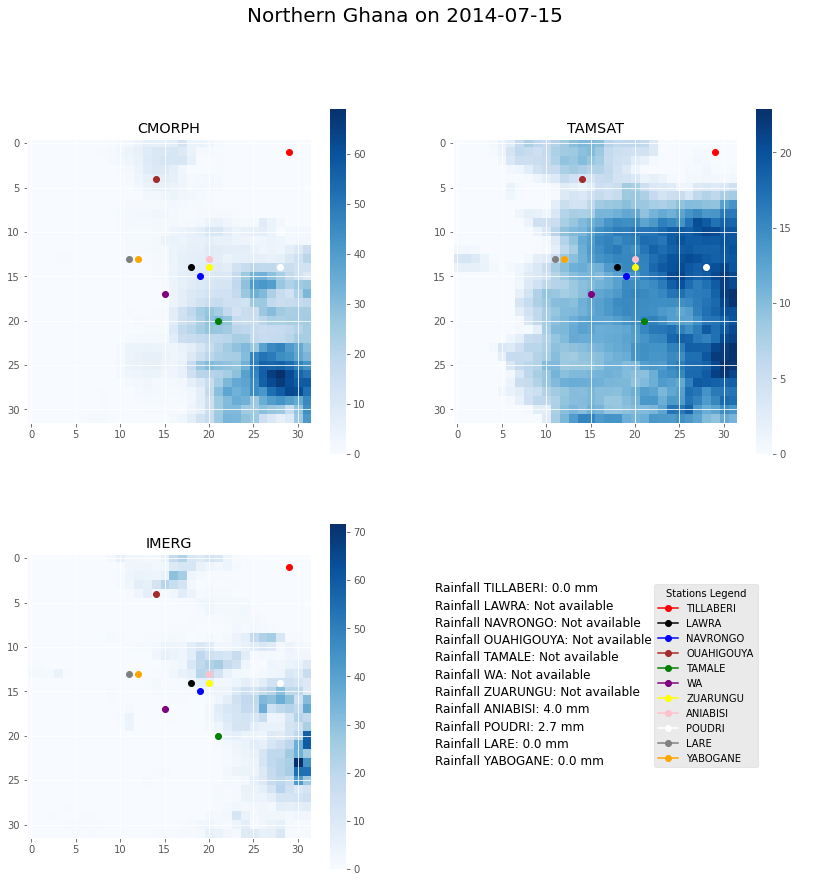

In [186]:
# select random image
ix = random.randint(0, x_tra.shape[0])

# create text with rainfall of groundtruth on this certain day

text = []

# No.1
if (df_cmorph.index[ ind_tra[ix] ] in gauge_TILLABERI.index):
  text.append( f'Rainfall TILLABERI: {gauge_TILLABERI.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]} mm' )
else:
  text.append( 'Rainfall TILLABERI: Not available' )

# No.2
if (df_cmorph.index[ ind_tra[ix] ] in gauge_LAWRA.index):
  text.append( f'Rainfall LAWRA: {gauge_LAWRA.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]} mm' )
else:
  text.append( 'Rainfall LAWRA: Not available' )

# No.3
if (df_cmorph.index[ ind_tra[ix] ] in gauge_NAVRONGO.index):
  text.append( f'Rainfall NAVRONGO: {gauge_NAVRONGO.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]} mm' )
else:
  text.append( 'Rainfall NAVRONGO: Not available' )

# No.4
if (df_cmorph.index[ ind_tra[ix] ] in gauge_OUAHIGOUYA.index):
  text.append( f'Rainfall OUAHIGOUYA: {gauge_OUAHIGOUYA.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]} mm' )
else:
  text.append( 'Rainfall OUAHIGOUYA: Not available' )

# No.5
if (df_cmorph.index[ ind_tra[ix] ] in gauge_TAMALE.index):
  text.append( f'Rainfall TAMALE: {gauge_TAMALE.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]} mm' )
else:
  text.append( 'Rainfall TAMALE: Not available' )

# No.6
if (df_cmorph.index[ ind_tra[ix] ] in gauge_WA.index):
  text.append( f'Rainfall WA: {gauge_WA.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]} mm' )
else:
  text.append( 'Rainfall WA: Not available' )

# No.7
if (df_cmorph.index[ ind_tra[ix] ] in gauge_ZUARUNGU.index):
  text.append( f'Rainfall ZUARUNGU: {gauge_ZUARUNGU.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]} mm' )
else:
  text.append( 'Rainfall ZUARUNGU: Not available' )

# No.8
if (df_cmorph.index[ ind_tra[ix] ] in gauge_ANIABISI.index):
  text.append( f'Rainfall ANIABISI: {gauge_ANIABISI.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]} mm' )
else:
  text.append( 'Rainfall ANIABISI: Not available' )

# No.9
if (df_cmorph.index[ ind_tra[ix] ] in gauge_POUDRI.index):
  text.append( f'Rainfall POUDRI: {gauge_POUDRI.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]} mm' )
else:
  text.append( 'Rainfall POUDRI: Not available' )

# No.10
if (df_cmorph.index[ ind_tra[ix] ] in gauge_LARE.index):
  text.append( f'Rainfall LARE: {gauge_LARE.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]} mm' )
else:
  text.append( 'Rainfall LARE: Not available' )

# No.11
if (df_cmorph.index[ ind_tra[ix] ] in gauge_YABOGANE.index):
  text.append( f'Rainfall YABOGANE: {gauge_YABOGANE.loc[ df_cmorph.index[ ind_tra[ix] ] ][0]} mm' )
else:
  text.append( 'Rainfall YABOGANE: Not available' )




# create subplots
plt.figure(figsize=(14, 14))
# plt.suptitle(f'Northern Ghana on {df_cmorph.index[ ind_tra[ix] ].date()}                                                                                           ', fontsize=15)  # LABEL={y_tra[ix]} | Rainfall {prec[ ind_tra[ ix ]]:.2f}mm/d.')
plt.suptitle(f'Northern Ghana on {df_cmorph.index[ ind_tra[ix] ].date()}', fontsize=20) 
plt.subplot()
colors = ['red', 'black', 'blue', 'brown', 'green', 'purple', 'yellow', 'pink', 'white', 'grey', 'orange']  # eleven colors



plt.subplot(221)
img = x_tra[ix, :, :, 0] * m_CMORPH
# plot image
plt.imshow(img, cmap='Blues')
for i in range(len(included_stations)):
  plt.plot(lat_lon[i][1], lat_lon[i][0], marker='o', color=colors[i], label=included_stations[i])
plt.colorbar()
plt.title(f'CMORPH')  
plt.figlegend(title='Stations Legend', loc=(0.80, 0.13))


plt.subplot(222)
img = x_tra[ix, :, :, 1] * m_TAMSAT
# plot image
plt.imshow(img, cmap='Blues')
for i in range(len(included_stations)):
  plt.plot(lat_lon[i][1], lat_lon[i][0], marker='o', color=colors[i], label=included_stations[i])
plt.colorbar()
plt.title(f'TAMSAT')  


plt.subplot(223)
img = x_tra[ix, :, :, 2] * m_IMERG
# plot image
plt.imshow(img, cmap='Blues')
for i in range(len(included_stations)):
  plt.plot(lat_lon[i][1], lat_lon[i][0], marker='o', color=colors[i], label=included_stations[i])
plt.colorbar()
plt.title(f'IMERG')

plt.subplot(224)  # use this to print rainfall
plt.axis('off')
for i in range(len(text)):
  plt.text(-0.05, 0.8 - 0.05 * i, text[i], fontsize=12);


# plt.tight_layout();

### Similarity indices:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( x_tra[ix, :, :, 0].flatten(), x_tra[ix, :, :, 1].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( x_tra[ix, :, :, 0].flatten(), x_tra[ix, :, :, 2].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( x_tra[ix, :, :, 1].flatten(), x_tra[ix, :, :, 2].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  0.18.
Correlation between CMORPH and IMERG:   0.06.
Correlation between TAMSAT and IMERG:   0.32.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = ((x_tra[ix, :, :, 0] // div) ).astype(int)
TAMSAT_classes = ((x_tra[ix, :, :, 1] // div) ).astype(int)
IMERG_classes  = ((x_tra[ix, :, :, 2] // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1 2 3 4 5 6 7]
TAMSAT has the following classes:  [0 1]
IMERG  has the following classes:  [0]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (8, 8, 1, 4) and homogeneity: 0.96.
TAMSAT has shape of: (8, 8, 1, 4) and homogeneity: 0.98.
IMERG  has shape of: (8, 8, 1, 4) and homogeneity: 1.00.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (256,).
TAMSAT has length of: (256,).
IMERG  has length of: (256,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.17.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.24.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.14.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = x_tra[ix, :, :, 0].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = x_tra[ix, :, :, 1].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  = x_tra[ix, :, :, 2].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.22.
CMORPH and IMERG  have a Hamming distance of: 0.25.
TAMSAT and IMERG  have a Hamming distance of: 0.22.


# Loss functions for imbalanced binary classification

We are going to test some more possible loss functions for this problem: focal-loss and weighted binary crossentropy. We import and define these loss functions here.

### 1. Focal-loss

In [ ]:
!pip install tensorflow_addons  # tensorflow_addons is not in collab by default

     |████████████████████████████████| 706kB 5.6MB/s 


In [ ]:
# import focal loss function

import tensorflow_addons as tfa
FocalLoss = tfa.losses.SigmoidFocalCrossEntropy(alpha=0.2, gamma=2.0)  # (alpha=0.2, gamma=2.0) in paper


def focal_loss_custom(alpha, gamma):  # (alpha=0.2, gamma=2.0) in paper

   def binary_focal_loss(y_true, y_pred):

      FocalLoss = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
      y_true_K = tf.ones_like(y_true)  # tf.ones_like instead of K.ones_like
      focal_loss = FocalLoss(y_true, y_pred)
      return focal_loss
      
   return binary_focal_loss

### 2. Weighted binary crossentropy

In [ ]:
"""
Created on Thu Feb 28 15:09:26 2019
@author: lhuang
"""


def dyn_weighted_bincrossentropy(true, pred):
    """
    Calculates weighted binary cross entropy. The weights are determined dynamically
    by the balance of each category. This weight is calculated for each batch.
    
    The weights are calculted by determining the number of 'pos' and 'neg' classes 
    in the true labels, then dividing by the number of total predictions.
    
    For example if there is 1 pos class, and 99 neg class, then the weights are 1/100 and 99/100.
    These weights can be applied so false negatives are weighted 99/100, while false postives are weighted
    1/100. This prevents the classifier from labeling everything negative and getting 99% accuracy.
    
    This can be useful for unbalanced catagories.
    """
    # get the total number of inputs
    num_pred = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) + keras.backend.sum(true)
    
    # get weight of values in 'pos' category
    zero_weight =  keras.backend.sum(true)/ num_pred +  keras.backend.epsilon() 
    
    # get weight of values in 'false' category
    one_weight = keras.backend.sum(keras.backend.cast(pred < 0.5, true.dtype)) / num_pred +  keras.backend.epsilon()

    # calculate the weight vector
    weights =  (1.0 - true) * zero_weight +  true * one_weight 
    
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)


def weighted_bincrossentropy(true, pred, weight_zero = 0.7086116, weight_one = 1.69839933):  # custom weights updated by the sklearn results 
    """
    Calculates weighted binary cross entropy. The weights are fixed.
        
    This can be useful for unbalanced catagories.
    
    Adjust the weights here depending on what is required.
    
    For example if there are 10x as many positive classes as negative classes,
        if you adjust weight_zero = 1.0, weight_one = 0.1, then false positives 
        will be penalize 10 times as much as false negatives.
    """
  
    # calculate the binary cross entropy
    bin_crossentropy = keras.backend.binary_crossentropy(true, pred)
    
    # apply the weights
    weights = true * weight_one + (1. - true) * weight_zero
    weighted_bin_crossentropy = weights * bin_crossentropy 

    return keras.backend.mean(weighted_bin_crossentropy)

# Stacked-up 3 datasets

In [ ]:
# stacked_up_model = tf.keras.models.load_model(folder+'stacked_up_model')

In [ ]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 28.18%.
 
The percentage of rainy days in the TESTING dataset is 28.51%.


In [ ]:
# create model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A1')(i)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A2')(x)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A3')(x)
x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B1')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B2')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B3')(x)
x = MaxPool2D(name='MaxPool2D_B')(x)

x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C3')(x)
x = MaxPool2D(name='MaxPool2D_C')(x)

x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

# x = GlobalAveragePooling2D(name='GlobalPooling')(x)

x = Dropout(0.20, name='Dropout_1')(x)
x = Dense(16, activation='tanh', name='Hidden')(x)

x = Dropout(0.20, name='Dropout_2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

model = Model(i, x, name='Classifier_CNN_from_scratch')

# model summary
print('Model summary')
print("---" * 10)
print(model.summary())

Model summary
------------------------------
Model: "Classifier_CNN_from_scratch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 32, 32, 8)         224       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 32, 32, 8)         584       
_________________________________________________________________
Convolutional_A3 (Conv2D)    (None, 32, 32, 8)         584       
_________________________________________________________________
MaxPool2D_A (MaxPooling2D)   (None, 16, 16, 8)         0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 16, 16, 16)        1168      
____________________________________________________________

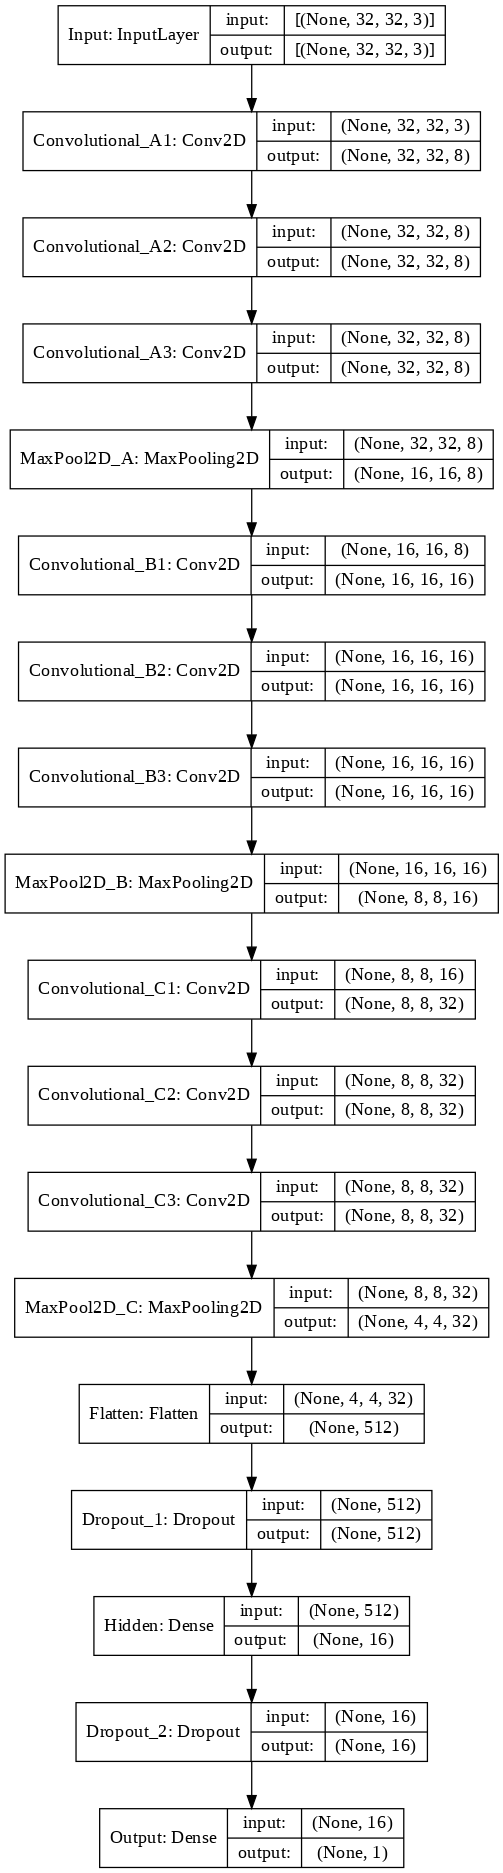

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.69620941 1.77414891]


In [ ]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = model.fit(x_tra, y_tra, verbose = 1, epochs=40, batch_size=64)

Epoch 1/40
201/201 [==============================] - 30s 139ms/step - loss: 0.6909 - accuracy: 0.6898 - precision_1: 0.3144 - recall_1: 0.0871
Epoch 2/40
201/201 [==============================] - 28s 139ms/step - loss: 0.6570 - accuracy: 0.7155 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 3/40
201/201 [==============================] - 28s 140ms/step - loss: 0.5690 - accuracy: 0.7159 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 4/40
201/201 [==============================] - 28s 141ms/step - loss: 0.5332 - accuracy: 0.7155 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 5/40
201/201 [==============================] - 28s 141ms/step - loss: 0.5091 - accuracy: 0.7130 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 6/40
201/201 [==============================] - 29s 143ms/step - loss: 0.5074 - accuracy: 0.7201 - precision_1: 0.3192 - recall_1: 0.0129
Epoch 7/40
201/201 [==============================] - 29s 142ms/step - loss: 0.5043 - accuracy: 0.7556 -

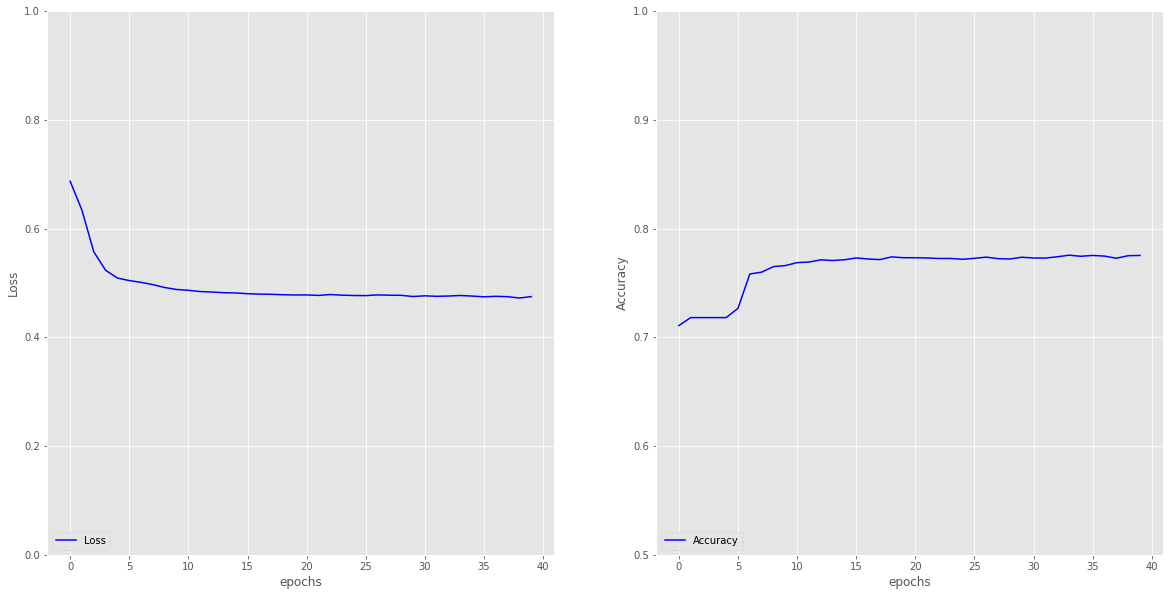

In [ ]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [ ]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [ ]:
# Evaluate the model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod = model.predict(x_tst)>thr_mod
count = sum(y_mod)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
13/13 [==============================] - 2s 139ms/step - loss: 0.4673 - accuracy: 0.7735 - precision_1: 0.6386 - recall_1: 0.4737
 
Test loss: 0.46725907921791077
Test accuracy: 0.7735496163368225
Test AUC: 0.6386430859565735
 
Total rainy days:
--------------------
The model predicted 678 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.81      0.89      0.85      2292
        Rain       0.64      0.47      0.54       914

    accuracy                           0.77      3206
   macro avg       0.72      0.68      0.70      3206
weighted avg       0.76      0.77      0.76      3206



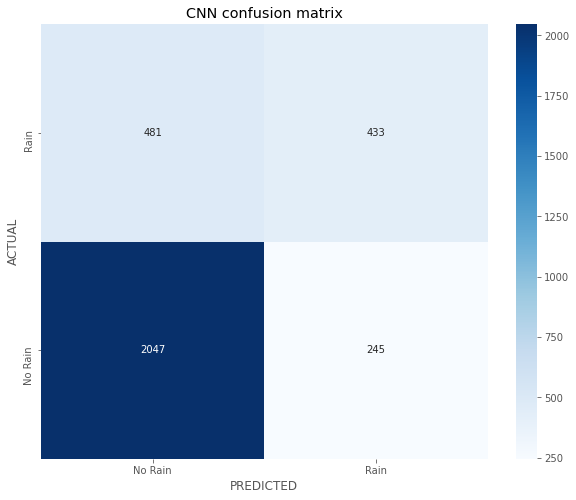

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

# y_mod = model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod))
print('\n', classification_report(y_tst, y_mod, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('CNN confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod = model.predict(x_tst)
miss_index = [i for i, y in enumerate(y_tst) if y != (y_mod[i][0] > thr_mod)]

In [ ]:
# visual inspection

print('Number of missclassified days:', len(miss_index), 'out of', len(y_tst))
print(' ')

for i in range(len(miss_index)):

  ix = miss_index[i]

  print(ix, y_tst[ix], y_mod[ix], y_mod[ix][0]>thr_mod)

Number of missclassified days: 1069 out of 4808
 
5 1.0 [0.13960865] False
6 1.0 [0.31633157] False
7 1.0 [0.09409451] False
13 0.0 [0.70788723] True
19 1.0 [0.16860086] False
24 0.0 [0.6158091] True
27 1.0 [0.42189357] False
35 1.0 [0.05631483] False
40 1.0 [0.20307562] False
46 0.0 [0.55440897] True
60 0.0 [0.68385196] True
61 0.0 [0.5848926] True
63 1.0 [0.41795754] False
65 1.0 [0.19164553] False
78 1.0 [0.13432756] False
82 1.0 [0.49333635] False
86 1.0 [0.36058187] False
87 1.0 [0.20581621] False
88 1.0 [0.46307653] False
92 1.0 [0.14698657] False
105 1.0 [0.29608846] False
107 1.0 [0.27229494] False
108 1.0 [0.23252165] False
114 1.0 [0.4562018] False
122 1.0 [0.48445874] False
127 1.0 [0.1653167] False
134 1.0 [0.49510893] False
136 0.0 [0.66048557] True
142 1.0 [0.06838679] False
146 1.0 [0.30770165] False
147 1.0 [0.2776566] False
149 0.0 [0.5608349] True
175 0.0 [0.6390121] True
177 0.0 [0.5896554] True
186 1.0 [0.3630269] False
188 1.0 [0.48088855] False
189 0.0 [0.625145] 

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod[ miss_index ] >= 0.3) & (y_mod[ miss_index ] <= 0.7)) / len(miss_index) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod[ miss_index ] >= 0.3) & (y_mod[ miss_index ] <= 0.7)), 'out of', len(miss_index), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 643 out of 1069 i.e. 60.14967259120674 %.


### Missclassified images

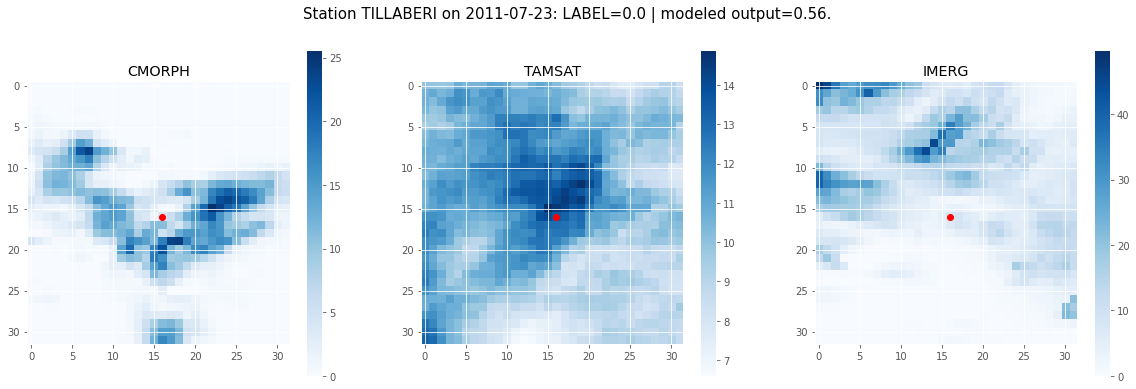

In [ ]:
# select random image
ix = miss_index[random.randint(0, len(miss_index))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]



# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | modeled output={y_mod[ix][0]:.2f}.', fontsize=15)
plt.subplot()

plt.subplot(131)
img = x_tst[ix, :, :, 0] * m_CMORPH
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH')  


plt.subplot(132)
img = x_tst[ix, :, :, 1] * m_TAMSAT
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT')  


plt.subplot(133)
img = x_tst[ix, :, :, 2] * m_IMERG
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'IMERG');  

### Similarity indices of stacked-up model's misclassifications:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( x_tst[ix, :, :, 0].flatten(), x_tst[ix, :, :, 1].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( x_tst[ix, :, :, 0].flatten(), x_tst[ix, :, :, 2].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( x_tst[ix, :, :, 1].flatten(), x_tst[ix, :, :, 2].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  0.18.
Correlation between CMORPH and IMERG:   0.06.
Correlation between TAMSAT and IMERG:   0.32.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = ((x_tst[ix, :, :, 0] // div) ).astype(int)
TAMSAT_classes = ((x_tst[ix, :, :, 1] // div) ).astype(int)
IMERG_classes  = ((x_tst[ix, :, :, 2] // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1 2 3 4 5 6 7]
TAMSAT has the following classes:  [0 1]
IMERG  has the following classes:  [0]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (8, 8, 1, 4) and homogeneity: 0.96.
TAMSAT has shape of: (8, 8, 1, 4) and homogeneity: 0.98.
IMERG  has shape of: (8, 8, 1, 4) and homogeneity: 1.00.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (256,).
TAMSAT has length of: (256,).
IMERG  has length of: (256,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.17.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.24.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.14.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = x_tst[ix, :, :, 0].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = x_tst[ix, :, :, 1].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  = x_tst[ix, :, :, 2].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.22.
CMORPH and IMERG  have a Hamming distance of: 0.25.
TAMSAT and IMERG  have a Hamming distance of: 0.22.


Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p saved_model
model.save(folder+'stacked_up_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/stacked_up_model/assets


# Individual models

Save the training and test datasets

In [ ]:
input_CMORPH = x_tra[:, :, :, 0]
input_TAMSAT = x_tra[:, :, :, 1]
input_IMERG  = x_tra[:, :, :, 2]
output_training = y_tra

input_st_CMORPH = x_tst[:, :, :, 0]
input_st_TAMSAT = x_tst[:, :, :, 1]
input_st_IMERG  = x_tst[:, :, :, 2]
output_testing = y_tst

print('Shapes of datasets')
print(input_TAMSAT.shape, output_training.shape, input_st_IMERG.shape, output_testing.shape)

Shapes of datasets
(11218, 32, 32) (11218,) (4808, 32, 32) (4808,)


In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


## 1. CMORPH model

In [ ]:
# repeat to (32, 32, 3)

x_tra = np.zeros((len(x_tra), pixels, pixels, 3))
x_tst = np.zeros((len(x_tst), pixels, pixels, 3))

x_tra[:, :, :, 0] = input_CMORPH
x_tra[:, :, :, 1] = input_CMORPH
x_tra[:, :, :, 2] = input_CMORPH

x_tst[:, :, :, 0] = input_st_CMORPH
x_tst[:, :, :, 1] = input_st_CMORPH
x_tst[:, :, :, 2] = input_st_CMORPH

print(x_tra.shape)

(11218, 32, 32, 3)


In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


In [ ]:
x_tra[1111, 12, 12]

array([0.00079802, 0.00079802, 0.00079802])

In [ ]:
# CMORPH_model = tf.keras.models.load_model(folder+'CMORPH_model')

In [ ]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 28.35%.
 
The percentage of rainy days in the TESTING dataset is 28.02%.


In [ ]:
# create CMORPH_model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A1')(i)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A2')(x)
# x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A3')(x)
x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B1')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B2')(x)
# x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B3')(x)
x = MaxPool2D(name='MaxPool2D_B')(x)

x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C3')(x)
x = MaxPool2D(name='MaxPool2D_C')(x)

x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

# x = GlobalAveragePooling2D(name='GlobalPooling')(x)

x = Dropout(0.10, name='Dropout_1')(x)
x = Dense(16, activation='tanh', name='Hidden')(x)

x = Dropout(0.10, name='Dropout_2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

CMORPH_model = Model(i, x, name='CMORPH_model')

# model summary
print('Model summary')
print("---" * 10)
print(CMORPH_model.summary())

Model summary
------------------------------
Model: "CMORPH_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 32, 32, 8)         224       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 32, 32, 8)         584       
_________________________________________________________________
MaxPool2D_A (MaxPooling2D)   (None, 16, 16, 8)         0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 16, 16, 16)        1168      
_________________________________________________________________
Convolutional_B2 (Conv2D)    (None, 16, 16, 16)        2320      
_________________________________________________________________
MaxPool2D

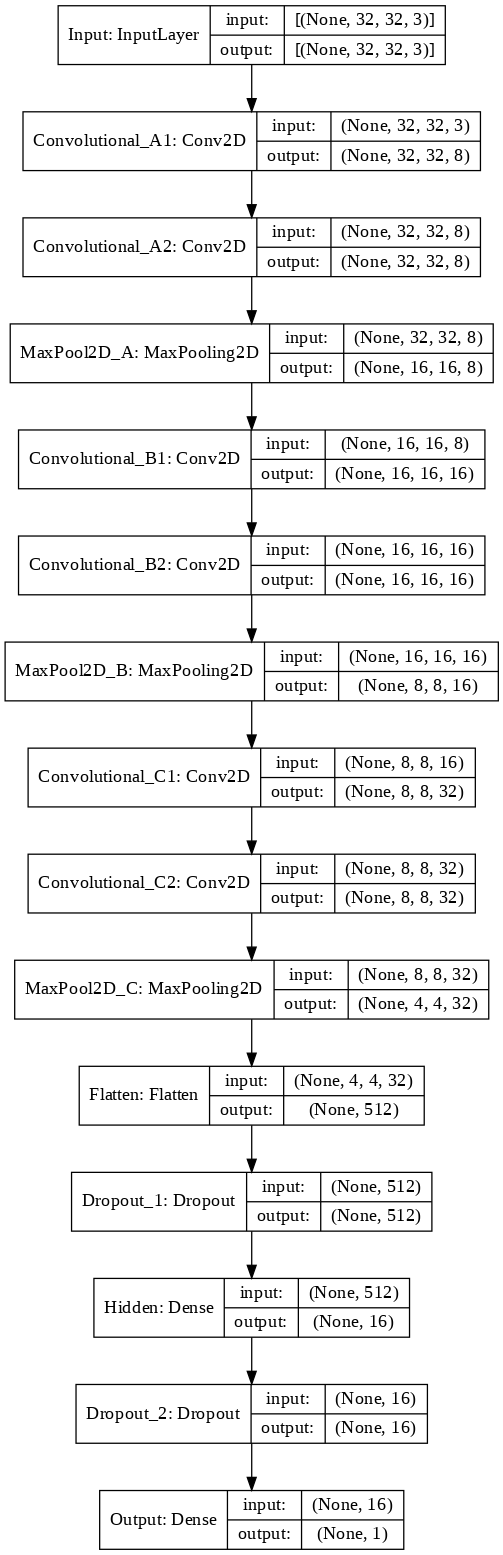

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(CMORPH_model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.6978104  1.76383648]


In [ ]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
CMORPH_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = CMORPH_model.fit(x_tra, y_tra, verbose = 1, epochs=20, batch_size=64)

Epoch 1/20
176/176 [==============================] - 18s 95ms/step - loss: 0.6914 - accuracy: 0.6717 - precision_5: 0.3452 - recall_5: 0.1488
Epoch 2/20
176/176 [==============================] - 17s 94ms/step - loss: 0.6779 - accuracy: 0.7124 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 3/20
176/176 [==============================] - 17s 94ms/step - loss: 0.6397 - accuracy: 0.7174 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 4/20
176/176 [==============================] - 17s 96ms/step - loss: 0.6072 - accuracy: 0.7152 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 5/20
176/176 [==============================] - 21s 118ms/step - loss: 0.5780 - accuracy: 0.7216 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 6/20
176/176 [==============================] - 16s 92ms/step - loss: 0.5609 - accuracy: 0.7127 - precision_5: 0.1704 - recall_5: 4.9993e-04
Epoch 7/20
176/176 [==============================] - 16s 92ms/step - loss: 0.5365 - accuracy: 0.7258 - p

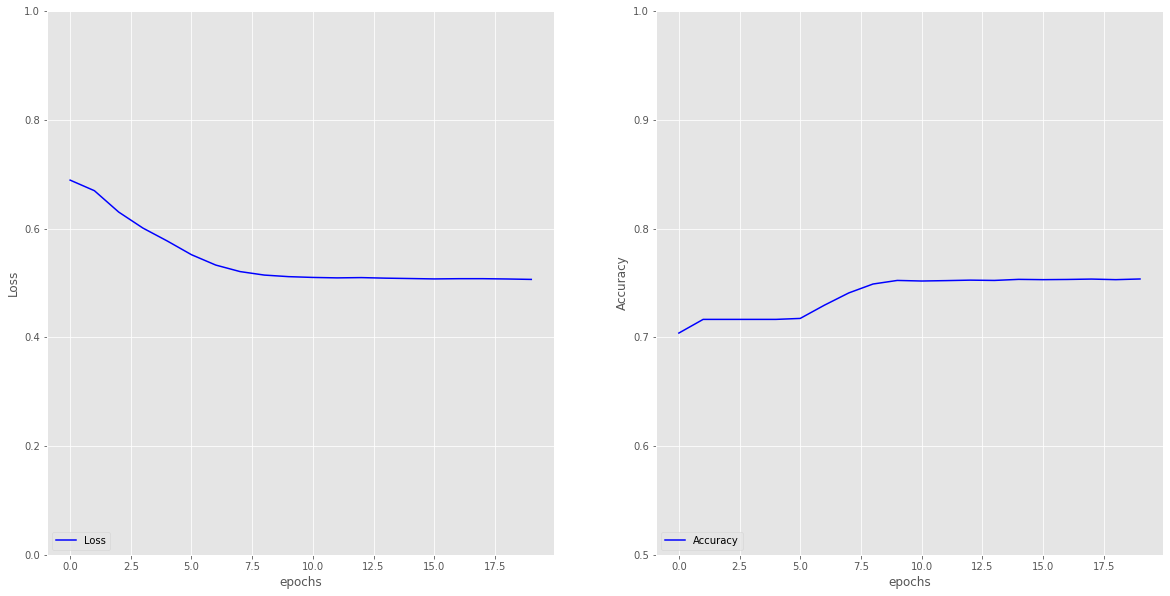

In [ ]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [ ]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [ ]:
# Evaluate the CMORPH_model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = CMORPH_model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod_CMORPH = CMORPH_model.predict(x_tst)>thr_mod
count = sum(y_mod_CMORPH)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
76/76 [==============================] - 3s 29ms/step - loss: 0.5000 - accuracy: 0.7552 - precision_5: 0.5982 - recall_5: 0.3846
 
Test loss: 0.49998506903648376
Test accuracy: 0.755199670791626
Test AUC: 0.5981523990631104
 
Total rainy days:
--------------------
The model predicted 866 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.79      0.90      0.84      3461
        Rain       0.60      0.38      0.47      1347

    accuracy                           0.76      4808
   macro avg       0.69      0.64      0.65      4808
weighted avg       0.74      0.76      0.74      4808



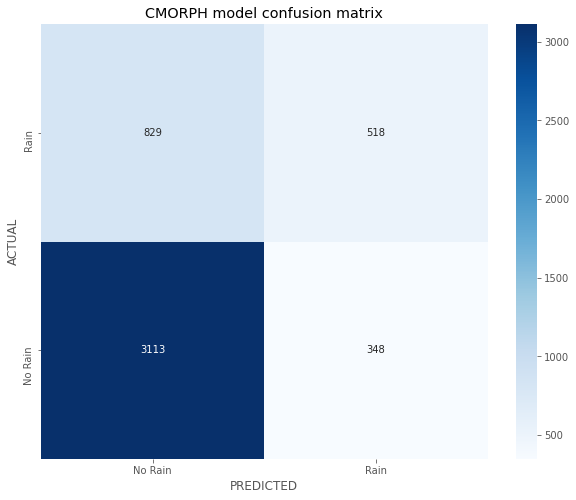

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

# y_mod_CMORPH = CMORPH_model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod_CMORPH))
print('\n', classification_report(y_tst, y_mod_CMORPH, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('CMORPH model confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod_CMORPH = CMORPH_model.predict(x_tst)
miss_index_CMORPH = [i for i, y in enumerate(y_tst) if y != (y_mod_CMORPH[i][0] > thr_mod)]

In [ ]:
# visual inspection

# print('Number of missclassified days:', len(miss_index_CMORPH), 'out of', len(y_tst))
# print(' ')

# for i in range(len(miss_index_CMORPH)):

#   ix = miss_index_CMORPH[i]

#   print(ix, y_tst[ix], y_mod_CMORPH[ix], y_mod_CMORPH[ix][0]>thr_mod)

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod_CMORPH[ miss_index_CMORPH ] >= 0.3) & (y_mod_CMORPH[ miss_index_CMORPH ] <= 0.7)) / len(miss_index_CMORPH) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod_CMORPH[ miss_index_CMORPH ] >= 0.3) & (y_mod_CMORPH[ miss_index_CMORPH ] <= 0.7)), 'out of', len(miss_index_CMORPH), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 728 out of 1177 i.e. 61.85216652506372 %.


### Missclassified images

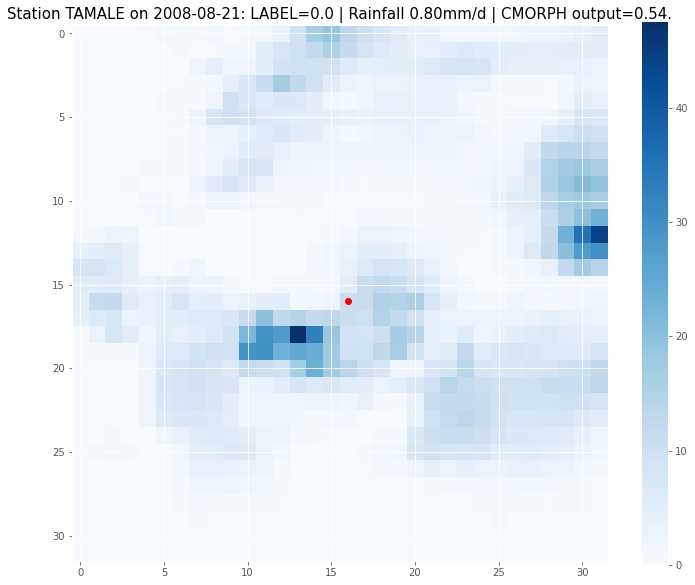

In [ ]:
# select random image
ix = miss_index_CMORPH[random.randint(0, len(miss_index_CMORPH))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]

# create subplots
plt.figure(figsize=(12, 10))
plt.title(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | CMORPH output={y_mod_CMORPH[ix][0]:.2f}.', fontsize=15)

img = x_tst[ix, :, :, 0] * m_CMORPH
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar();

Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p UpdatedResolutions_saved_model
CMORPH_model.save(folder+'UpdatedResolutions_CMORPH_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/UpdatedResolutions_CMORPH_model/assets


## 2. TAMSAT model

In [ ]:
# repeat to (32, 32, 3)

x_tra = np.zeros((len(x_tra), pixels, pixels, 3))
x_tst = np.zeros((len(x_tst), pixels, pixels, 3))

x_tra[:, :, :, 0] = input_TAMSAT
x_tra[:, :, :, 1] = input_TAMSAT
x_tra[:, :, :, 2] = input_TAMSAT

x_tst[:, :, :, 0] = input_st_TAMSAT
x_tst[:, :, :, 1] = input_st_TAMSAT
x_tst[:, :, :, 2] = input_st_TAMSAT

print(x_tra.shape)

(11218, 32, 32, 3)


In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


In [ ]:
x_tra[1111, 12, 12, 0]

0.036916677499025094

In [ ]:
# TAMSAT_model = tf.keras.models.load_model(folder+'TAMSAT_model')

In [ ]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 28.35%.
 
The percentage of rainy days in the TESTING dataset is 28.02%.


In [ ]:
# create TAMSAT_model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A1')(i)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A2')(x)
# x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A3')(x)
x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B1')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B2')(x)
# x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B3')(x)
x = MaxPool2D(name='MaxPool2D_B')(x)

x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C3')(x)
x = MaxPool2D(name='MaxPool2D_C')(x)

x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

# x = GlobalAveragePooling2D(name='GlobalPooling')(x)

x = Dropout(0.10, name='Dropout_1')(x)
x = Dense(16, activation='tanh', name='Hidden')(x)

x = Dropout(0.10, name='Dropout_2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

TAMSAT_model = Model(i, x, name='TAMSAT_model')

# model summary
print('Model summary')
print("---" * 10)
print(TAMSAT_model.summary())

Model summary
------------------------------
Model: "TAMSAT_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 32, 32, 8)         224       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 32, 32, 8)         584       
_________________________________________________________________
MaxPool2D_A (MaxPooling2D)   (None, 16, 16, 8)         0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 16, 16, 16)        1168      
_________________________________________________________________
Convolutional_B2 (Conv2D)    (None, 16, 16, 16)        2320      
_________________________________________________________________
MaxPool2D

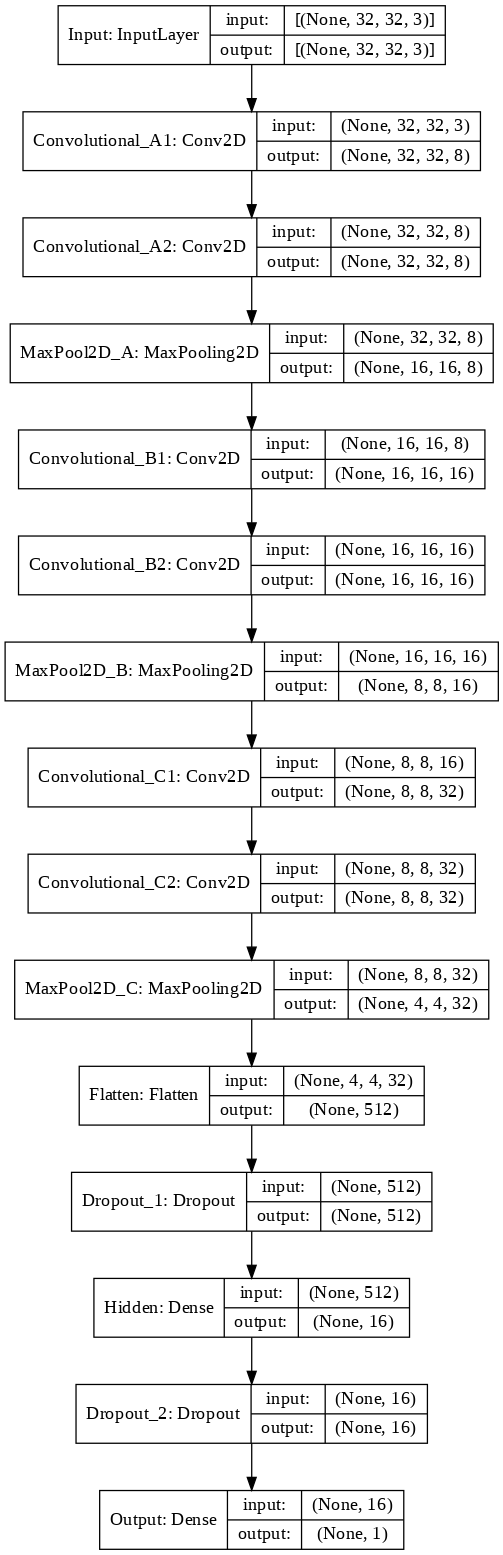

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(TAMSAT_model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.6978104  1.76383648]


In [ ]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
TAMSAT_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = TAMSAT_model.fit(x_tra, y_tra, verbose = 1, epochs=30, batch_size=64)

Epoch 1/30
176/176 [==============================] - 16s 86ms/step - loss: 0.6909 - accuracy: 0.6801 - precision_6: 0.3059 - recall_6: 0.1110
Epoch 2/30
176/176 [==============================] - 20s 115ms/step - loss: 0.6763 - accuracy: 0.7161 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 3/30
176/176 [==============================] - 18s 102ms/step - loss: 0.6466 - accuracy: 0.7140 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 4/30
176/176 [==============================] - 16s 90ms/step - loss: 0.6146 - accuracy: 0.7199 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 5/30
176/176 [==============================] - 16s 90ms/step - loss: 0.6001 - accuracy: 0.7110 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 6/30
176/176 [==============================] - 16s 90ms/step - loss: 0.5769 - accuracy: 0.7114 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 7/30
176/176 [==============================] - 16s 91ms/step - loss: 0.5518 - accuracy: 0.716

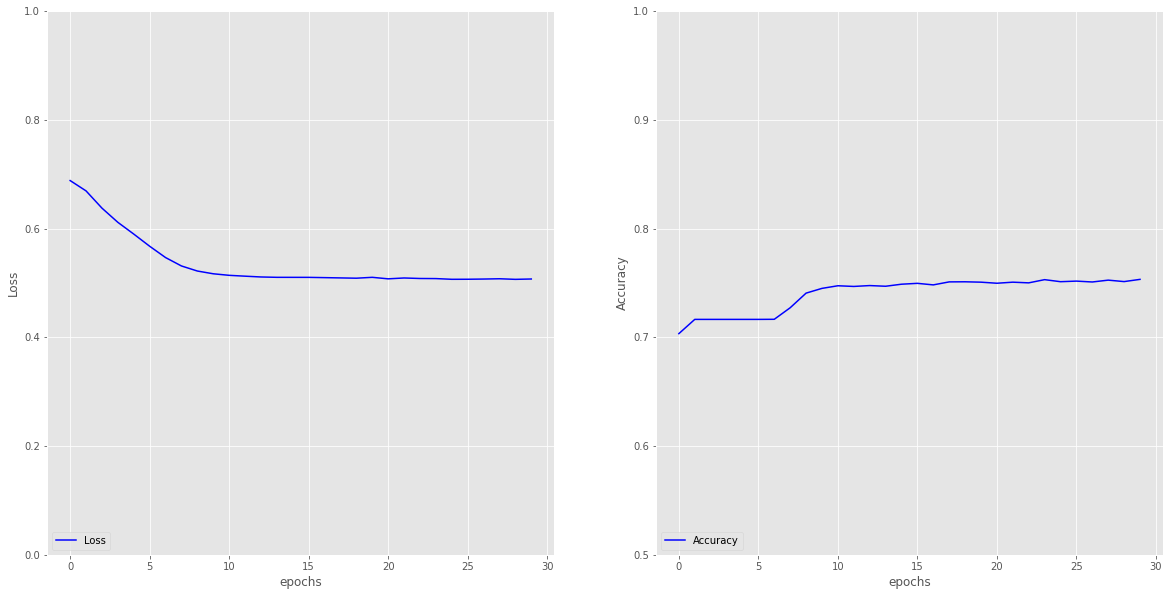

In [ ]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [ ]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [ ]:
# Evaluate the TAMSAT_model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = TAMSAT_model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod_TAMSAT = TAMSAT_model.predict(x_tst)>thr_mod
count = sum(y_mod_TAMSAT)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
76/76 [==============================] - 3s 28ms/step - loss: 0.4986 - accuracy: 0.7585 - precision_6: 0.6069 - recall_6: 0.3920
 
Test loss: 0.4985538423061371
Test accuracy: 0.7585274577140808
Test AUC: 0.6068965792655945
 
Total rainy days:
--------------------
The model predicted 870 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.79      0.90      0.84      3461
        Rain       0.61      0.39      0.48      1347

    accuracy                           0.76      4808
   macro avg       0.70      0.65      0.66      4808
weighted avg       0.74      0.76      0.74      4808



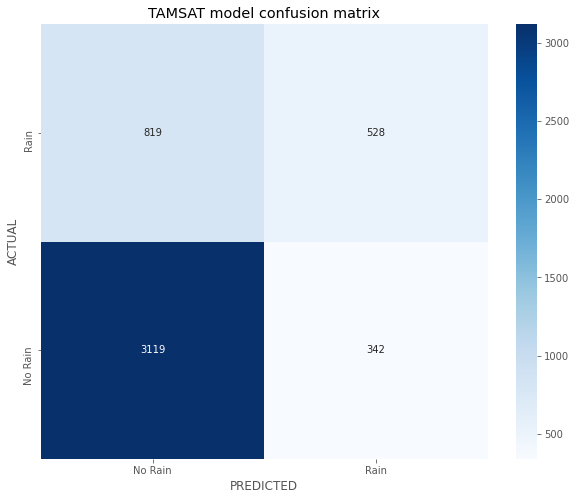

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

# y_mod_TAMSAT = TAMSAT_model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod_TAMSAT))
print('\n', classification_report(y_tst, y_mod_TAMSAT, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('TAMSAT model confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod_TAMSAT = TAMSAT_model.predict(x_tst)
miss_index_TAMSAT = [i for i, y in enumerate(y_tst) if y != (y_mod_TAMSAT[i][0] > thr_mod)]

In [ ]:
# # visual inspection

# print('Number of missclassified days:', len(miss_index_TAMSAT), 'out of', len(y_tst))
# print(' ')

# for i in range(len(miss_index_TAMSAT)):

#   ix = miss_index_TAMSAT[i]

#   print(ix, y_tst[ix], y_mod_TAMSAT[ix], y_mod_TAMSAT[ix][0]>thr_mod)

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod_TAMSAT[ miss_index_TAMSAT ] >= 0.3) & (y_mod_TAMSAT[ miss_index_TAMSAT ] <= 0.7)) / len(miss_index_TAMSAT) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod_TAMSAT[ miss_index_TAMSAT ] >= 0.3) & (y_mod_TAMSAT[ miss_index_TAMSAT ] <= 0.7)), 'out of', len(miss_index_TAMSAT), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 719 out of 1161 i.e. 61.92937123169682 %.


### Missclassified images

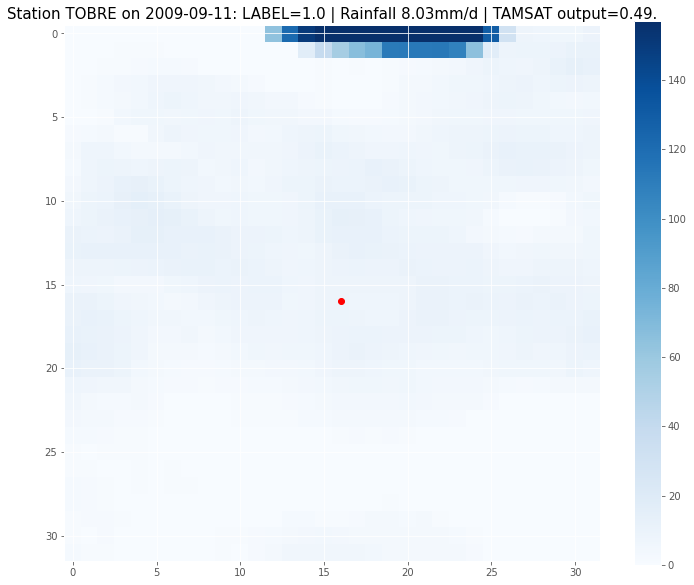

In [ ]:
# select random image
ix = miss_index_TAMSAT[random.randint(0, len(miss_index_TAMSAT))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]



# create subplots
plt.figure(figsize=(12, 10))
plt.title(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | TAMSAT output={y_mod_TAMSAT[ix][0]:.2f}.', fontsize=15)


img = x_tst[ix, :, :, 0] * m_TAMSAT

# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar();

Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p UpdatedResolutions_saved_model
TAMSAT_model.save(folder+'UpdatedResolutions_TAMSAT_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/UpdatedResolutions_TAMSAT_model/assets


## 3. IMERG model

In [ ]:
# repeat to (32, 32, 3)

x_tra = np.zeros((len(x_tra), pixels, pixels, 3))
x_tst = np.zeros((len(x_tst), pixels, pixels, 3))

x_tra[:, :, :, 0] = input_IMERG
x_tra[:, :, :, 1] = input_IMERG
x_tra[:, :, :, 2] = input_IMERG

x_tst[:, :, :, 0] = input_st_IMERG
x_tst[:, :, :, 1] = input_st_IMERG
x_tst[:, :, :, 2] = input_st_IMERG

print(x_tra.shape)

(11218, 32, 32, 3)


In [ ]:
x_tra[1111, 12, 12, 0]

0.0

In [ ]:
print( input_st_CMORPH[1435, 12, 12], input_st_TAMSAT[1435, 12, 12], input_st_IMERG[1435, 12, 12] )

0.049479569352095264 0.060054595086442224 0.011670117507865228


In [ ]:
# IMERG_model = tf.keras.models.load_model(folder+'IMERG_model')

In [ ]:
per = sum(y_tra) * 100 / len(y_tra)
print(f'The percentage of rainy days in the TRAINING dataset is {per:.2f}%.')

per = sum(y_tst) * 100 / len(y_tst)
print(' ')
print(f'The percentage of rainy days in the TESTING dataset is {per:.2f}%.')

The percentage of rainy days in the TRAINING dataset is 28.35%.
 
The percentage of rainy days in the TESTING dataset is 28.02%.


In [ ]:
# create IMERG_model

i = Input(shape=x_tra[0].shape, name='Input')

x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A1')(i)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A2')(x)
x = Conv2D(8, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_A3')(x)
x = MaxPool2D(name='MaxPool2D_A')(x)  # Max pooling performs better than Average pooling

x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B1')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B2')(x)
x = Conv2D(16, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_B3')(x)
x = MaxPool2D(name='MaxPool2D_B')(x)

x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C1')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C2')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same', name='Convolutional_C3')(x)
x = MaxPool2D(name='MaxPool2D_C')(x)

x = Flatten(name='Flatten')(x)  # Flatten or Globalpooling

# x = GlobalAveragePooling2D(name='GlobalPooling')(x)

x = Dropout(0.20, name='Dropout_1')(x)
x = Dense(16, activation='tanh', name='Hidden')(x)

x = Dropout(0.20, name='Dropout_2')(x)
x = Dense(1, activation='sigmoid', name='Output')(x)

IMERG_model = Model(i, x, name='IMERG_model')

# model summary
print('Model summary')
print("---" * 10)
print(IMERG_model.summary())

Model summary
------------------------------
Model: "IMERG_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Convolutional_A1 (Conv2D)    (None, 32, 32, 8)         224       
_________________________________________________________________
Convolutional_A2 (Conv2D)    (None, 32, 32, 8)         584       
_________________________________________________________________
Convolutional_A3 (Conv2D)    (None, 32, 32, 8)         584       
_________________________________________________________________
MaxPool2D_A (MaxPooling2D)   (None, 16, 16, 8)         0         
_________________________________________________________________
Convolutional_B1 (Conv2D)    (None, 16, 16, 16)        1168      
_________________________________________________________________
Convolutio

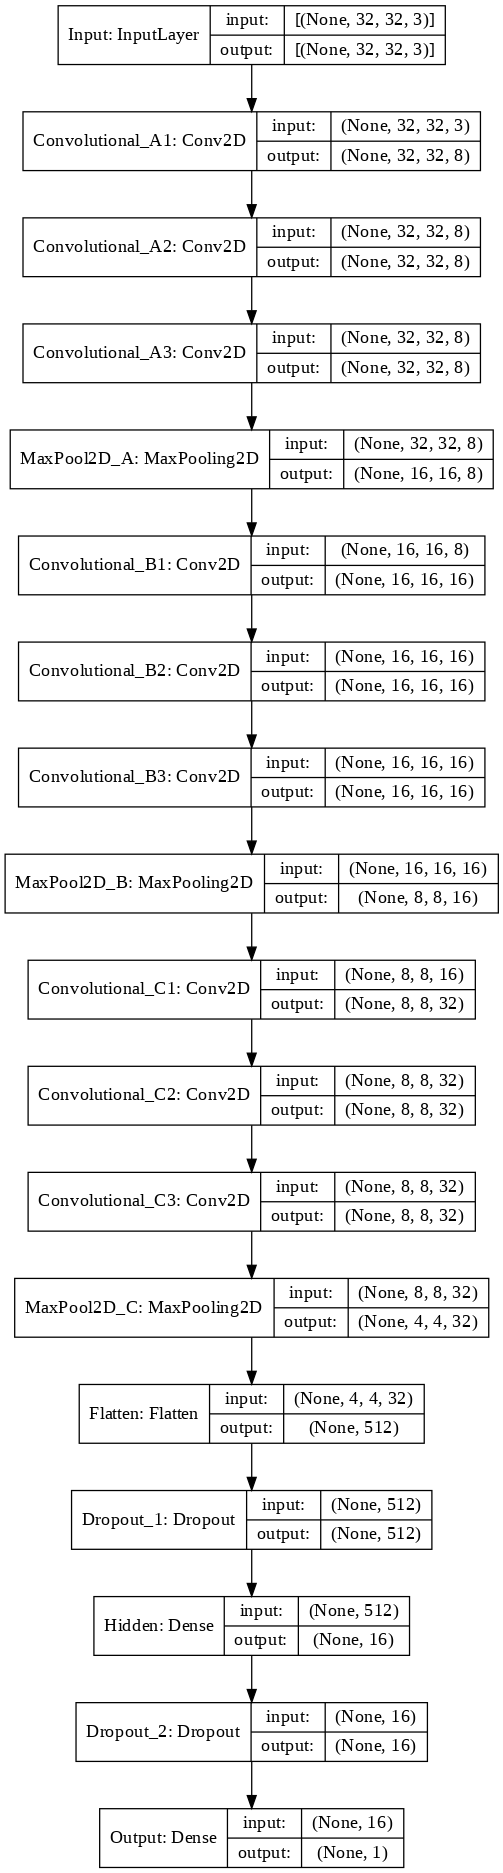

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(IMERG_model, show_shapes=True, dpi=92)

In [ ]:
# Calculate the weights for each class so that we can balance the data
w = class_weight.compute_class_weight('balanced',
                                       np.unique(y_tra),
                                       y_tra
                                     )

weights = {0: w[0], 1: w[1]}

print('weights for 0 and 1:', w)

weights for 0 and 1: [0.6978104  1.76383648]


In [ ]:
metrics = ['accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall(),
          ]

# compile the model
IMERG_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=metrics)

# fit the model and save the trajectories of loss and accuracy for training and test dataset
r_CNN = IMERG_model.fit(x_tra, y_tra, verbose = 1, epochs=30, batch_size=64)

Epoch 1/30
176/176 [==============================] - 26s 141ms/step - loss: 0.6901 - accuracy: 0.7053 - precision_7: 0.4117 - recall_7: 0.0860
Epoch 2/30
176/176 [==============================] - 25s 141ms/step - loss: 0.6520 - accuracy: 0.7222 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 3/30
176/176 [==============================] - 25s 141ms/step - loss: 0.5977 - accuracy: 0.7180 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 4/30
176/176 [==============================] - 25s 142ms/step - loss: 0.5884 - accuracy: 0.7182 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 5/30
176/176 [==============================] - 25s 141ms/step - loss: 0.5734 - accuracy: 0.7171 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 6/30
176/176 [==============================] - 25s 141ms/step - loss: 0.5520 - accuracy: 0.7122 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00
Epoch 7/30
176/176 [==============================] - 25s 141ms/step - loss: 0.5317 - accuracy: 

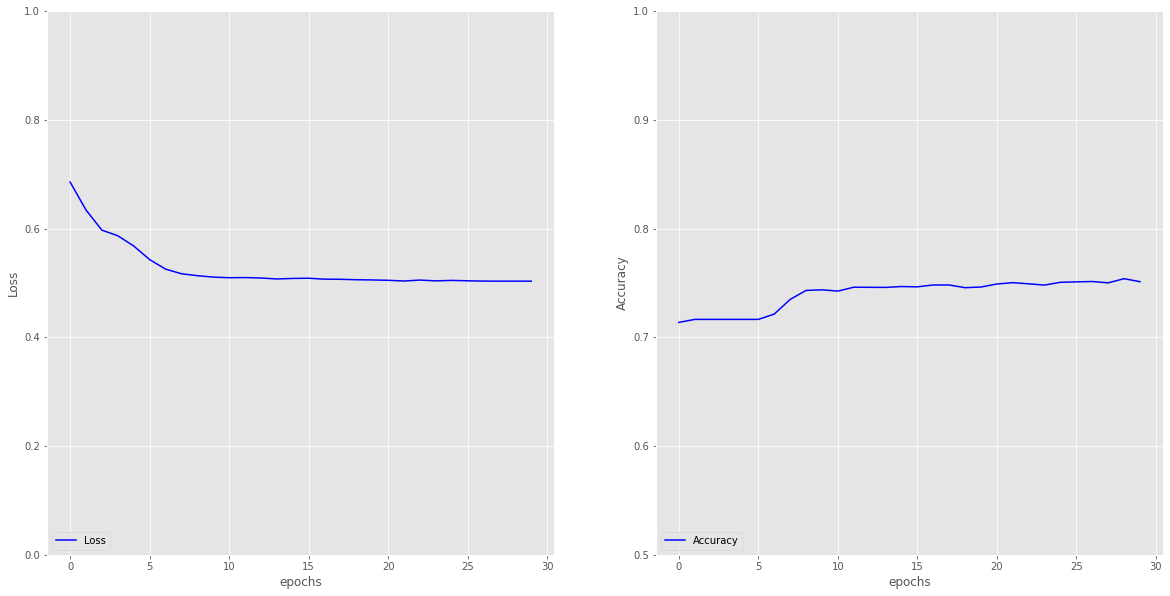

In [ ]:
# plot results
f, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].plot(r_CNN.history['loss'], label = 'Loss', color = 'b')
# ax[0].plot(r_CNN.history['val_loss'], label = 'validation Loss', color = 'b', ls= '--')
ax[0].legend(loc="lower left")
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(r_CNN.history['accuracy'], label = 'Accuracy', color = 'b')
# ax[1].plot(r_CNN.history['val_accuracy'], label = 'validation Accuracy', color = 'b', ls= '--')
ax[1].legend(loc="lower left")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_ylim(0.5, 1.0);

Choose the modeled values wet/dry threshold:

In [ ]:
thr_mod = 0.5  # everything below 'No Rain', everything above 'Rain'

Results on test dataset:

In [ ]:
# Evaluate the IMERG_model on the test data using `evaluate`

print("Evaluate on test data")
print("---" * 10)

results = IMERG_model.evaluate(x_tst, y_tst, batch_size=64)

print(' ')
print("Test loss:", results[0])
print("Test accuracy:", results[1])
print("Test AUC:", results[2])
print(' ')


# Compare the total rainy days in all the datasets combined

y_mod_IMERG = IMERG_model.predict(x_tst)>thr_mod
count = sum(y_mod_IMERG)

print('Total rainy days:')
print('--' * 10)
print('The model predicted', count[0], 'rainy days.')
print('There were actually', sum(y), 'rainy days.')

Evaluate on test data
------------------------------
76/76 [==============================] - 3s 39ms/step - loss: 0.4893 - accuracy: 0.7681 - precision_7: 0.6184 - recall_7: 0.4499
 
Test loss: 0.48925283551216125
Test accuracy: 0.7680948376655579
Test AUC: 0.6183673739433289
 
Total rainy days:
--------------------
The model predicted 980 rainy days.
There were actually 4527.0 rainy days.



               precision    recall  f1-score   support

     No Rain       0.81      0.89      0.85      3461
        Rain       0.62      0.45      0.52      1347

    accuracy                           0.77      4808
   macro avg       0.71      0.67      0.68      4808
weighted avg       0.75      0.77      0.76      4808



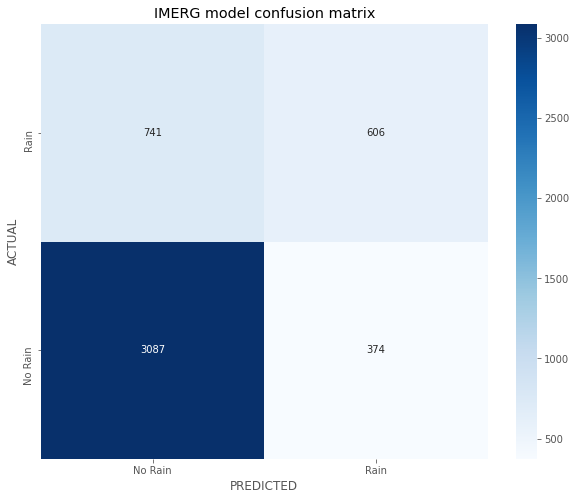

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

# y_mod_IMERG = IMERG_model.predict(x_tst)>thr_mod

conf_matrix.append(confusion_matrix(y_tst, y_mod_IMERG))
print('\n', classification_report(y_tst, y_mod_IMERG, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('IMERG model confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

Let's see the missclassified images:

In [ ]:
# get index of misclassified images
y_mod_IMERG = IMERG_model.predict(x_tst)
miss_index_IMERG = [i for i, y in enumerate(y_tst) if y != (y_mod_IMERG[i][0] > thr_mod)]

In [ ]:
# # visual inspection

# print('Number of missclassified days:', len(miss_index_IMERG), 'out of', len(y_tst))
# print(' ')

# for i in range(len(miss_index_IMERG)):

#   ix = miss_index_IMERG[i]

#   print(ix, y_tst[ix], y_mod_IMERG[ix], y_mod_IMERG[ix][0]>thr_mod)

### Boarderline fails
Number of produced outputs between 0.3 and 0.7

In [ ]:
per = np.sum((y_mod_IMERG[ miss_index_IMERG ] >= 0.3) & (y_mod_IMERG[ miss_index_IMERG ] <= 0.7)) / len(miss_index_IMERG) * 100
print('The boarderline (between 0.3 and 0.7) missclassified days are', np.sum((y_mod_IMERG[ miss_index_IMERG ] >= 0.3) & (y_mod_IMERG[ miss_index_IMERG ] <= 0.7)), 'out of', len(miss_index_IMERG), 'i.e.', per, '%.')

The boarderline (between 0.3 and 0.7) missclassified days are 759 out of 1115 i.e. 68.07174887892377 %.


### Missclassified images

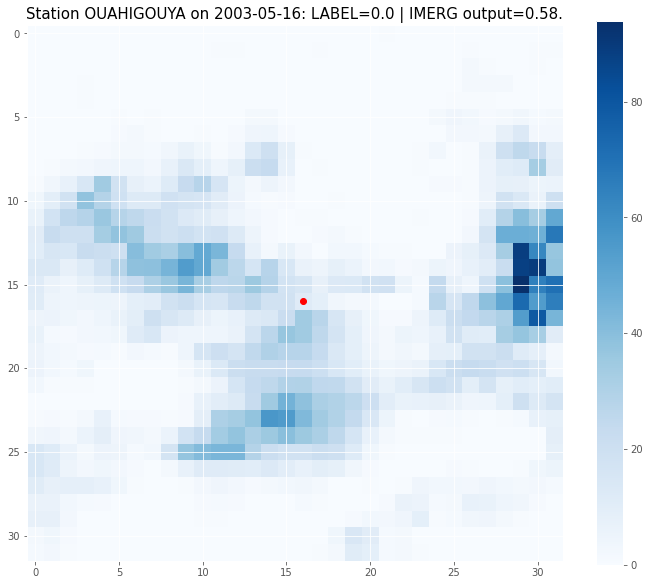

In [ ]:
# select random image
ix = miss_index_IMERG[random.randint(0, len(miss_index_IMERG))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]


# create subplots
plt.figure(figsize=(12, 10))
plt.title(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | IMERG output={y_mod_IMERG[ix][0]:.2f}.', fontsize=15)


img = x_tst[ix, :, :, 2] * m_IMERG

# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar();

Save model:

In [ ]:
# Save the entire model as a SavedModel.

!mkdir -p UpdatedResolutions_saved_model
IMERG_model.save(folder+'UpdatedResolutions_IMERG_model')

INFO:tensorflow:Assets written to: ./gdrive/My Drive/Deep-Learning/UpdatedResolutions_IMERG_model/assets


# Majority vote

### Assess individual datasets

In [ ]:
idx = np.intersect1d(miss_index_CMORPH, miss_index_TAMSAT, miss_index_IMERG)


per = len(idx) * 100 / min(len(miss_index_CMORPH), len(miss_index_TAMSAT), len(miss_index_IMERG))
print(f'Percentage of common misclasifications in (smallest) misclasification index: {per:.2f}%.')
print(' ')

per = len(idx) * 100 / len(y_tst)
# print(len(idx), idx)  # common index of 2
print(f'Percentage of common misclasifications out of total test dataset: {per:.2f}%.')
print(' ')
per = 100 - per
print(f'Can we assume that the maximum possible accuracy is {per:.2f}% ?')

Percentage of common misclasifications in (smallest) misclasification index: 89.69%.
 
Percentage of common misclasifications out of total test dataset: 20.80%.
 
Can we assume that the maximum possible accuracy is 79.20% ?


## Majority vote Alternative No.1

Assessing binary output

In [ ]:
y_mod = y_mod_CMORPH + y_mod_TAMSAT + y_mod_IMERG

# get index of misclassified images
miss_index = [i for i, y in enumerate(y_tst) if y != (y_mod[i][0]>1.5)]

# visual inspection

print('Number of missclassified days:', len(miss_index), 'out of', len(y_tst))
print(' ')

for i in range(len(miss_index)):

  ix = miss_index[i]

  print(ix, y_tst[ix], y_mod[ix], y_mod[ix][0]>1.5)

Number of missclassified days: 1139 out of 4808
 
3 1.0 [1.3857642] False
5 1.0 [0.29967833] False
6 1.0 [0.79008585] False
7 1.0 [0.37404722] False
13 0.0 [1.5300277] True
19 1.0 [0.39770246] False
21 1.0 [1.2670395] False
24 0.0 [1.9111099] True
27 1.0 [1.399032] False
31 0.0 [1.6967027] True
35 1.0 [0.35551605] False
40 1.0 [0.85813403] False
60 0.0 [1.6001468] True
61 0.0 [1.7271564] True
63 1.0 [1.4988558] False
65 1.0 [0.7779326] False
69 1.0 [1.3898144] False
75 1.0 [1.4028064] False
77 1.0 [1.2132828] False
78 1.0 [0.44090608] False
82 1.0 [0.918917] False
86 1.0 [1.4223664] False
87 1.0 [0.86356366] False
88 1.0 [0.57058275] False
92 1.0 [0.67454696] False
105 1.0 [0.9663665] False
107 1.0 [0.77207446] False
108 1.0 [1.0023355] False
114 1.0 [1.2887716] False
116 0.0 [1.610935] True
120 1.0 [1.4295876] False
121 1.0 [0.86643827] False
122 1.0 [1.2638617] False
125 1.0 [1.3385415] False
127 1.0 [0.59894395] False
132 1.0 [1.3246648] False
134 1.0 [0.9071933] False
136 0.0 [1.92

In [ ]:
per = np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)) / len(miss_index) * 100
print('The boarderline (between 0.9 and 2.1) missclassified days are', np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)), 'out of', len(miss_index), 'i.e.', per, '%.')

The boarderline (between 0.9 and 2.1) missclassified days are 745 out of 1139 i.e. 65.40825285338016 %.


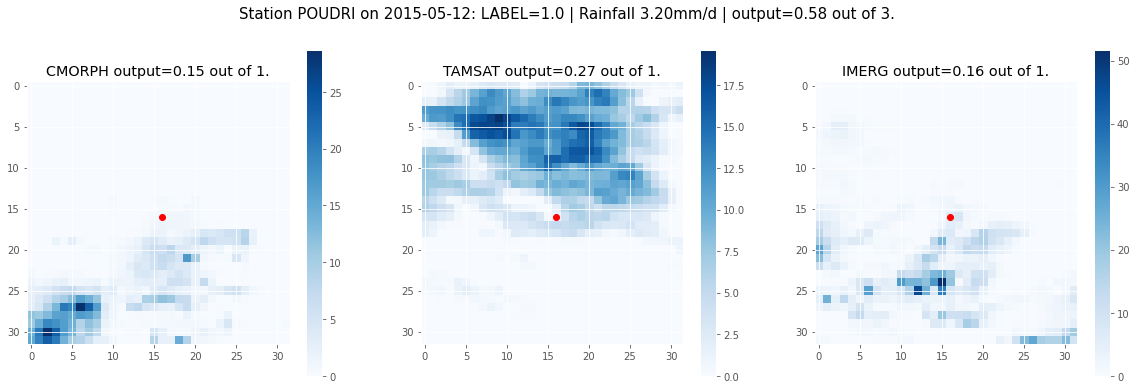

In [ ]:
# select random image
ix = miss_index[random.randint(0, len(miss_index))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]



# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | output={y_mod[ix][0]:.2f} out of 3.', fontsize=15)
plt.subplot()

plt.subplot(131)
img = input_st_CMORPH[ix, :, :] * m_CMORPH
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH output={y_mod_CMORPH[ix][0]:.2f} out of 1.')  


plt.subplot(132)
img = input_st_TAMSAT[ix, :, :] * m_TAMSAT
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT output={y_mod_TAMSAT[ix][0]:.2f} out of 1.')   


plt.subplot(133)
img = input_st_IMERG[ix, :, :] * m_IMERG
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'IMERG output={y_mod_IMERG[ix][0]:.2f} out of 1.');  

### Similarity indices of Majority No.1 model's misclassifications:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_TAMSAT[ix, :, :].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( input_st_TAMSAT[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  -0.28.
Correlation between CMORPH and IMERG:   0.14.
Correlation between TAMSAT and IMERG:   -0.29.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = (( input_st_CMORPH[ix, :, :] // div) ).astype(int)
TAMSAT_classes = (( input_st_TAMSAT[ix, :, :] // div) ).astype(int)
IMERG_classes  = (( input_st_IMERG[ix, :, :]  // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1 2 3 4 5]
TAMSAT has the following classes:  [0 1 2 3 4 5 6]
IMERG  has the following classes:  [0 1 2 3 4 5 6]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (7, 7, 1, 4) and homogeneity: 0.96.
TAMSAT has shape of: (7, 7, 1, 4) and homogeneity: 0.90.
IMERG  has shape of: (7, 7, 1, 4) and homogeneity: 0.95.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (196,).
TAMSAT has length of: (196,).
IMERG  has length of: (196,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.32.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.09.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.34.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = input_st_CMORPH[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = input_st_TAMSAT[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  =  input_st_IMERG[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.62.
CMORPH and IMERG  have a Hamming distance of: 0.20.
TAMSAT and IMERG  have a Hamming distance of: 0.70.


Confusion matrix

In [ ]:
y_mod = y_mod>1.5  # threshold between 0 and 3

per = sum(y_mod) * 100 / len(y_mod)
print(f'Percentage of modeled wet day: {per[0]:.2f}%.')

Percentage of modeled wet day: 17.55%.



               precision    recall  f1-score   support

     No Rain       0.79      0.91      0.85      3461
        Rain       0.62      0.39      0.48      1347

    accuracy                           0.76      4808
   macro avg       0.71      0.65      0.66      4808
weighted avg       0.75      0.76      0.74      4808



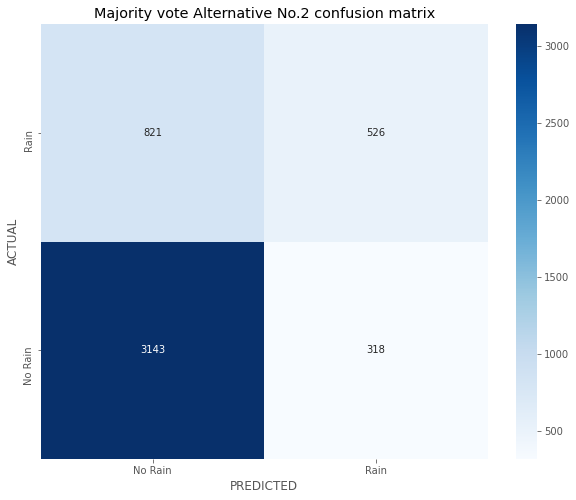

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

conf_matrix.append(confusion_matrix(y_tst, y_mod))
print('\n', classification_report(y_tst, y_mod, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('Majority vote Alternative No.2 confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');

## Majority vote Alternative No.2

Assessing raw output

In [ ]:
y_mod = y_mod_CMORPH + y_mod_TAMSAT + y_mod_IMERG

# get index of misclassified images
miss_index = [i for i, y in enumerate(y_tst) if y != (y_mod[i][0]>1.5)]

# visual inspection

print('Number of missclassified days:', len(miss_index), 'out of', len(y_tst))
print(' ')

for i in range(len(miss_index)):

  ix = miss_index[i]

  print(ix, y_tst[ix], y_mod[ix], y_mod[ix][0]>1.5)

Number of missclassified days: 1139 out of 4808
 
3 1.0 [1.3857642] False
5 1.0 [0.29967833] False
6 1.0 [0.79008585] False
7 1.0 [0.37404722] False
13 0.0 [1.5300277] True
19 1.0 [0.39770246] False
21 1.0 [1.2670395] False
24 0.0 [1.9111099] True
27 1.0 [1.399032] False
31 0.0 [1.6967027] True
35 1.0 [0.35551605] False
40 1.0 [0.85813403] False
60 0.0 [1.6001468] True
61 0.0 [1.7271564] True
63 1.0 [1.4988558] False
65 1.0 [0.7779326] False
69 1.0 [1.3898144] False
75 1.0 [1.4028064] False
77 1.0 [1.2132828] False
78 1.0 [0.44090608] False
82 1.0 [0.918917] False
86 1.0 [1.4223664] False
87 1.0 [0.86356366] False
88 1.0 [0.57058275] False
92 1.0 [0.67454696] False
105 1.0 [0.9663665] False
107 1.0 [0.77207446] False
108 1.0 [1.0023355] False
114 1.0 [1.2887716] False
116 0.0 [1.610935] True
120 1.0 [1.4295876] False
121 1.0 [0.86643827] False
122 1.0 [1.2638617] False
125 1.0 [1.3385415] False
127 1.0 [0.59894395] False
132 1.0 [1.3246648] False
134 1.0 [0.9071933] False
136 0.0 [1.92

In [ ]:
per = np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)) / len(miss_index) * 100
print('The boarderline (between 0.9 and 2.1) missclassified days are', np.sum((y_mod[ miss_index ] >= 0.9) & (y_mod[ miss_index ] <= 2.1)), 'out of', len(miss_index), 'i.e.', per, '%.')

The boarderline (between 0.9 and 2.1) missclassified days are 745 out of 1139 i.e. 65.40825285338016 %.


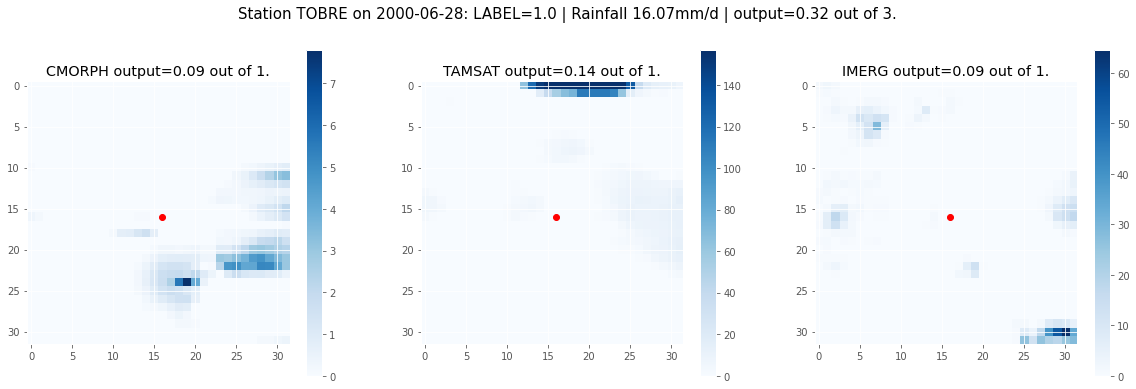

In [ ]:
# select random image
ix = miss_index[random.randint(0, len(miss_index))]
station = locations.index[ locations[ 'station_latitude(dec.degree)' ] == df.iloc[ind_tst[ix]] ][0]



# create subplots
plt.figure(figsize=(20, 6))
plt.suptitle(f'Station {station} on {df.index[ ind_tst[ix] ].date()}: LABEL={y_tst[ix]} | Rainfall {prec[ ind_tst[ ix ]]:.2f}mm/d | output={y_mod[ix][0]:.2f} out of 3.', fontsize=15)
plt.subplot()

plt.subplot(131)
img = input_st_CMORPH[ix, :, :] * m_CMORPH
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'CMORPH output={y_mod_CMORPH[ix][0]:.2f} out of 1.')  


plt.subplot(132)
img = input_st_TAMSAT[ix, :, :] * m_TAMSAT
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'TAMSAT output={y_mod_TAMSAT[ix][0]:.2f} out of 1.')   


plt.subplot(133)
img = input_st_IMERG[ix, :, :] * m_IMERG
# plot image
plt.imshow(img, cmap='Blues')
plt.plot(pixels/2, pixels/2, 'ro')
plt.colorbar()
plt.title(f'IMERG output={y_mod_IMERG[ix][0]:.2f} out of 1.');  

### Similarity indices of Majority No.2 model's misclassifications:

1. Correlation coefficient

In [ ]:
corr_CMORPH_TAMSAT = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_TAMSAT[ix, :, :].flatten() )[0][1]
corr_CMORPH_IMERG  = np.corrcoef( input_st_CMORPH[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]
corr_TAMSAT_IMERG  = np.corrcoef( input_st_TAMSAT[ix, :, :].flatten(), input_st_IMERG[ix, :, :].flatten() )[0][1]

print(f'Correlation between CMORPH and TAMSAT:  {corr_CMORPH_TAMSAT:.2f}.')
print(f'Correlation between CMORPH and IMERG:   {corr_CMORPH_IMERG:.2f}.')
print(f'Correlation between TAMSAT and IMERG:   {corr_TAMSAT_IMERG:.2f}.')

Correlation between CMORPH and TAMSAT:  -0.01.
Correlation between CMORPH and IMERG:   0.01.
Correlation between TAMSAT and IMERG:   -0.02.


2. Co-occurrence matrix (coma)

First create **X** classes representing different intervals of normalized rain intensities (0.0 - 0.1, 0.1 - 0.2, etc.)

In [ ]:
num_classes = 50  # choose the number of classes to be created
div = 1 / num_classes

CMORPH_classes = (( input_st_CMORPH[ix, :, :] // div) ).astype(int)
TAMSAT_classes = (( input_st_TAMSAT[ix, :, :] // div) ).astype(int)
IMERG_classes  = (( input_st_IMERG[ix, :, :]  // div) ).astype(int)

Let's see how many unique classes each image has.

In [ ]:
print('CMORPH has the following classes: ', np.unique( CMORPH_classes ))
print('TAMSAT has the following classes: ', np.unique( TAMSAT_classes ))
print('IMERG  has the following classes: ', np.unique( IMERG_classes  ))

CMORPH has the following classes:  [0 1]
TAMSAT has the following classes:  [ 0  1  2  3  4  5  6 12 17 19 20 21 23 33 35 38 41 47 49]
IMERG  has the following classes:  [0 1 2 3 4 6 7]


Calculate the co-occurance matrices

In [ ]:
from skimage.feature import greycomatrix, greycoprops

angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
levels = max( np.max(CMORPH_classes), np.max(TAMSAT_classes), np.max(IMERG_classes) ) + 1  # maximum values will be used as levels
# print(levels)

coma_CMORPH = greycomatrix( CMORPH_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_CMORPH  = greycoprops( coma_CMORPH, prop='homogeneity' )[0, 0]

coma_TAMSAT = greycomatrix( TAMSAT_classes, distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_TAMSAT  = greycoprops( coma_TAMSAT, prop='homogeneity' )[0, 0]

coma_IMERG  = greycomatrix( IMERG_classes , distances=[1], angles=angles, levels=levels, symmetric=True, normed=True)
homogeneity_IMERG  = greycoprops( coma_IMERG, prop='homogeneity' )[0, 0]


# print shape and homogeneity
print(f'CMORPH has shape of: {coma_CMORPH.shape} and homogeneity: {homogeneity_CMORPH:.2f}.' )
print(f'TAMSAT has shape of: {coma_TAMSAT.shape} and homogeneity: {homogeneity_TAMSAT:.2f}.' )
print(f'IMERG  has shape of: {coma_IMERG.shape} and homogeneity: {homogeneity_IMERG:.2f}.' )

CMORPH has shape of: (50, 50, 1, 4) and homogeneity: 1.00.
TAMSAT has shape of: (50, 50, 1, 4) and homogeneity: 0.95.
IMERG  has shape of: (50, 50, 1, 4) and homogeneity: 0.98.


From co-occurance matrices to co-occurence vectors. We will simplify the above vector by counting all relations only once (np.unique) so that the generated outputs have the same lengths.

In [ ]:
# matrices to vectors
cove_CMORPH = coma_CMORPH.flatten()  # np.unique
cove_TAMSAT = coma_TAMSAT.flatten()  # np.unique
cove_IMERG  = coma_IMERG.flatten()  # np.unique

# print length
print(f'CMORPH has length of: {cove_CMORPH.shape}.' )
print(f'TAMSAT has length of: {cove_TAMSAT.shape}.' )
print(f'IMERG  has length of: {cove_IMERG.shape}.' )

CMORPH has length of: (10000,).
TAMSAT has length of: (10000,).
IMERG  has length of: (10000,).


Compute the Jensen-Shannon distance of the three different co-occurence matrices. This function takes two probability functions (spatial signatures in our case) A and B, and calculates entropy values (H). 

The Jenson-Shannon distance is a value between 0 and 1, where 0 means that two probability functions are identical, and 1 means that they have nothing in common.

In [ ]:
from scipy.spatial import distance

js_CMORPH_TAMSAT = distance.jensenshannon(cove_CMORPH, cove_TAMSAT)
js_CMORPH_IMERG  = distance.jensenshannon(cove_CMORPH, cove_IMERG)
js_TAMSAT_IMERG  = distance.jensenshannon(cove_IMERG, cove_TAMSAT)

# print
print(f'CMORPH and TAMSAT have a Jensen-Shannon distance of: {js_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Jensen-Shannon distance of: {js_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Jensen-Shannon distance of: {js_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Jensen-Shannon distance of: 0.23.
CMORPH and IMERG  have a Jensen-Shannon distance of: 0.10.
TAMSAT and IMERG  have a Jensen-Shannon distance of: 0.19.


3. Perceptual hash

Average out (32, 32) to (8, 8)

In [ ]:
CMORPH_64 = input_st_CMORPH[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
TAMSAT_64 = input_st_TAMSAT[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)
IMERG_64  =  input_st_IMERG[ix, :, :].reshape([8, 32//8, 8, 32//8]).mean(3).mean(1)

# print shapes
print(f'CMORPH has shape of: {CMORPH_64.shape}.' )
print(f'TAMSAT has shape of: {TAMSAT_64.shape}.' )
print(f'IMERG  has shape of: {IMERG_64.shape}.' )

CMORPH has shape of: (8, 8).
TAMSAT has shape of: (8, 8).
IMERG  has shape of: (8, 8).


Calculate the hash

In [ ]:
CMORPH_64 = ( CMORPH_64 > CMORPH_64.mean() ).astype(int)
TAMSAT_64 = ( TAMSAT_64 > TAMSAT_64.mean() ).astype(int)
IMERG_64  = ( IMERG_64  > IMERG_64.mean()  ).astype(int)

Calculate Hamming's distance

In [ ]:
from scipy.spatial import distance

# 0: identical and 1: opposite
hamming_CMORPH_TAMSAT = distance.hamming(CMORPH_64.flatten(), TAMSAT_64.flatten())
hamming_CMORPH_IMERG  = distance.hamming(CMORPH_64.flatten(), IMERG_64.flatten())
hamming_TAMSAT_IMERG  = distance.hamming(IMERG_64.flatten() , TAMSAT_64.flatten())


# print
print(f'CMORPH and TAMSAT have a Hamming distance of: {hamming_CMORPH_TAMSAT:.2f}.' )
print(f'CMORPH and IMERG  have a Hamming distance of: {hamming_CMORPH_IMERG:.2f}.' )
print(f'TAMSAT and IMERG  have a Hamming distance of: {hamming_TAMSAT_IMERG:.2f}.' )

CMORPH and TAMSAT have a Hamming distance of: 0.20.
CMORPH and IMERG  have a Hamming distance of: 0.28.
TAMSAT and IMERG  have a Hamming distance of: 0.23.


Confusion matrix

In [ ]:
y_mod = y_mod>1.5  # threshold between 0 and 3

per = sum(y_mod) * 100 / len(y_mod)
print(f'Percentage of modeled wet day: {per[0]:.2f}%.')

Percentage of modeled wet day: 17.55%.



               precision    recall  f1-score   support

     No Rain       0.79      0.91      0.85      3461
        Rain       0.62      0.39      0.48      1347

    accuracy                           0.76      4808
   macro avg       0.71      0.65      0.66      4808
weighted avg       0.75      0.76      0.74      4808



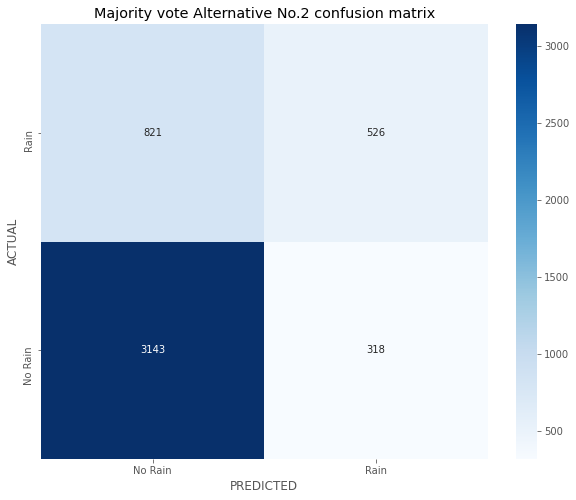

In [ ]:
# confusion matrix, training dataset

conf_matrix = []

# Precision quantifies the number of positive class predictions that actually belong to the positive class.
# Recall quantifies the number of positive class predictions made out of all positive examples in the dataset.
# F-Measure provides a single score that balances both the concerns of precision and recall in one number.

labels = ['No Rain', 'Rain']

conf_matrix.append(confusion_matrix(y_tst, y_mod))
print('\n', classification_report(y_tst, y_mod, target_names = labels))  

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(conf_matrix[0], annot=True, fmt=".0f", ax=ax, cmap = 'Blues')

ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
ax.set_ylim(0, 2)  # needed for text allignment

plt.title('Majority vote Alternative No.2 confusion matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')

plt.show()
print('\n');